In [125]:
# Import The Following Libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import sys
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from nba_api.stats.endpoints import teamgamelog
from nba_api.stats.static import teams
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.models import load_model
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam
from itertools import permutations
from tensorflow.keras.callbacks import EarlyStopping
from nba_api.stats.endpoints import leaguedashteamstats
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import keras_tuner as kt
import seaborn as sns
import joblib

In [112]:
# Install the Following Dependencies: 
!pip install --upgrade seaborn
!pip install nba_api pandas numpy tensorflow matplotlib scikit-learn 
!{sys.executable} -m pip install keras-tuner --upgrade 

  Using cached nba_api-1.10.0-py3-none-any.whl.metadata (5.8 kB)
ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python3.9 -m pip install --upgrade pip


In [95]:
########## PHASE 0: DATA CURATION ##########

In [100]:
# STEP 1: Load all CSVs
df_kaggle = pd.read_csv("NBA-BoxScores-2024-2025.csv")
df_api = pd.read_csv("nba_all_games_2023_2025.csv")
df_elo = pd.read_csv("nbaallelo.csv")

In [58]:
# Dataframe 1: All Data 2023, 2024

# STEP 2: Clean Kaggle and aggregate player-level stats to team level
df_kaggle.columns = df_kaggle.columns.str.strip()
kaggle_team_stats = df_kaggle.groupby(['GAME_ID', 'TEAM_ABBREVIATION']).agg({
    'PTS': 'sum',
    'REB': 'sum',
    'AST': 'sum',
    'FG_PCT': 'mean',
    'TO': 'sum',
    'PLUS_MINUS': 'sum'
}).reset_index()

# STEP 3: Prepare API data (2024–25)
df_api.columns = df_api.columns.str.strip()
df_api.rename(columns={'Game_ID': 'GAME_ID'}, inplace=True)
df_api['TEAM_ID'] = df_api['TEAM_ID'].astype(str)
team_id_map = df_kaggle[['TEAM_ID', 'TEAM_ABBREVIATION']].drop_duplicates()
team_id_map['TEAM_ID'] = team_id_map['TEAM_ID'].astype(str)
df_api = df_api.merge(team_id_map, on='TEAM_ID', how='left')
df_api['GAME_DATE'] = pd.to_datetime(df_api['GAME_DATE'], errors='coerce')

# Filter seasons starting with "202"
api_filtered = df_api[df_api['SEASON'].astype(str).str.startswith("202")]

# Dynamically select available columns
base_cols = ['GAME_ID', 'TEAM_ABBREVIATION', 'PTS', 'REB', 'AST', 'FG_PCT']
optional_cols = ['TO', 'PLUS_MINUS']
available_cols = base_cols + [col for col in optional_cols if col in df_api.columns]
api_team_stats = api_filtered[available_cols].copy()

# STEP 4: Combine Kaggle and API box scores
team_stats_all = pd.concat([kaggle_team_stats, api_team_stats], ignore_index=True)

# STEP 5: Assign random team order per GAME_ID
team_stats_all = team_stats_all.sample(frac=1).reset_index(drop=True)  # shuffle

team_stats_all['TEAM_ORDER'] = team_stats_all.groupby('GAME_ID').cumcount()

# Only keep games with exactly 2 teams
valid_games = team_stats_all.groupby('GAME_ID').filter(lambda x: len(x) == 2)
team_stats_sorted = valid_games.sort_values(['GAME_ID', 'TEAM_ORDER'])

# STEP 6: Split into TEAM0 and TEAM1
team0 = team_stats_sorted[team_stats_sorted['TEAM_ORDER'] == 0].copy()
team1 = team_stats_sorted[team_stats_sorted['TEAM_ORDER'] == 1].copy()
team0.columns = ['GAME_ID'] + [f'TEAM0_{col}' for col in team0.columns[1:]]
team1.columns = ['GAME_ID'] + [f'TEAM1_{col}' for col in team1.columns[1:]]
df_games = pd.merge(team0, team1, on='GAME_ID')
df_games['TEAM0_WIN'] = (df_games['TEAM0_PTS'] > df_games['TEAM1_PTS']).astype(int)
df_games['TEAM1_WIN'] = (df_games['TEAM1_PTS'] > df_games['TEAM0_PTS']).astype(int)

# STEP 6.5: Flip rows to create unbiased team ordering
df_flipped = df_games.copy()

# Identify all TEAM0_ and TEAM1_ columns
team0_cols = [col for col in df_flipped.columns if col.startswith("TEAM0_")]
team1_cols = [col for col in df_flipped.columns if col.startswith("TEAM1_")]

# Temporarily rename to avoid collision
df_flipped.rename(columns={c0: f"TEMP_{c0}" for c0 in team0_cols}, inplace=True)

# Rename TEAM1_ to TEAM0_
df_flipped.rename(columns={c1: c1.replace("TEAM1_", "TEAM0_") for c1 in team1_cols}, inplace=True)

# Rename TEMP_TEAM0_ to TEAM1_
df_flipped.rename(columns={f"TEMP_{c0}": c0.replace("TEAM0_", "TEAM1_") for c0 in team0_cols}, inplace=True)

# Recalculate win columns
df_flipped['TEAM0_WIN'] = (df_flipped['TEAM0_PTS'] > df_flipped['TEAM1_PTS']).astype(int)
df_flipped['TEAM1_WIN'] = (df_flipped['TEAM1_PTS'] > df_flipped['TEAM0_PTS']).astype(int)

# Combine datasets
df_games_augmented = pd.concat([df_games, df_flipped], ignore_index=True)

# STEP 7: Add GAME_DATEs to TEAM0 and TEAM1 using df_api
df_api_dates = df_api[['GAME_ID', 'GAME_DATE', 'TEAM_ABBREVIATION']].copy()
team0_dates = df_api_dates.rename(columns={
    'TEAM_ABBREVIATION': 'TEAM0_TEAM_ABBREVIATION',
    'GAME_DATE': 'TEAM0_GAME_DATE'
})
team1_dates = df_api_dates.rename(columns={
    'TEAM_ABBREVIATION': 'TEAM1_TEAM_ABBREVIATION',
    'GAME_DATE': 'TEAM1_GAME_DATE'
})

df_games_augmented = pd.merge(df_games_augmented, team0_dates, on=['GAME_ID', 'TEAM0_TEAM_ABBREVIATION'], how='left')
df_games_augmented = pd.merge(df_games_augmented, team1_dates, on=['GAME_ID', 'TEAM1_TEAM_ABBREVIATION'], how='left')

# Step 7.5: Fix ELO data to have normal abbreviations

# Fix ELO data to recent seasons and normalize team abbreviations
df_elo.columns = df_elo.columns.str.strip()
df_elo = df_elo.rename(columns={'team_id': 'TEAM_ABBREVIATION', 'date_game': 'GAME_DATE'})
df_elo['GAME_DATE'] = pd.to_datetime(df_elo['GAME_DATE'], errors='coerce')

# Map legacy team names to standard abbreviations
elo_team_map = {
    'Knicks': 'NYK', 'Warriors': 'GSW', 'Wizards': 'WAS', 'Celtics': 'BOS',
    'Spurs': 'SAS', '76ers': 'PHI', 'Sixers': 'PHI', 'Cavaliers': 'CLE',
    'Lakers': 'LAL', 'Kings': 'SAC', 'Hawks': 'ATL', 'Bulls': 'CHI',
    'Thunder': 'OKC', 'Rockets': 'HOU', 'Bucks': 'MIL', 'Clippers': 'LAC',
    'Trailblazers': 'POR', 'Blazers': 'POR', 'Pacers': 'IND', 'Nuggets': 'DEN',
    'Nets': 'BKN', 'Jazz': 'UTA', 'Mavericks': 'DAL', 'Hornets': 'CHA',
    'Heat': 'MIA', 'Timberwolves': 'MIN', 'Magic': 'ORL', 'Grizzlies': 'MEM',
    'Raptors': 'TOR', 'Pelicans': 'NOP', 'Pistons': 'DET'
}

df_elo['TEAM_ABBREVIATION'] = df_elo['fran_id'].map(elo_team_map)

# Filter to 2023 and later, drop nulls
elo_recent = df_elo[df_elo['year_id'] >= 2023][['TEAM_ABBREVIATION', 'GAME_DATE', 'elo_i']].dropna()

# STEP 8: Merge ELO ratings for both teams

# Merge ELO for TEAM0
df_games_augmented = pd.merge(
    df_games_augmented,
    elo_recent,
    left_on=['TEAM0_TEAM_ABBREVIATION', 'TEAM0_GAME_DATE'],
    right_on=['TEAM_ABBREVIATION', 'GAME_DATE'],
    how='left'
).rename(columns={'elo_i': 'TEAM0_ELO'}).drop(columns=['TEAM_ABBREVIATION', 'GAME_DATE'])

# Merge ELO for TEAM1
df_games_augmented = pd.merge(
    df_games_augmented,
    elo_recent,
    left_on=['TEAM1_TEAM_ABBREVIATION', 'TEAM1_GAME_DATE'],
    right_on=['TEAM_ABBREVIATION', 'GAME_DATE'],
    how='left'
).rename(columns={'elo_i': 'TEAM1_ELO'}).drop(columns=['TEAM_ABBREVIATION', 'GAME_DATE'])

# Save to CSV
df_games_augmented.to_csv("final_merged_games.csv", index=False)
display(df_games_augmented.head(50))

# Diagnostics:

print("Latest GAME_DATE in df_elo:", df_elo['GAME_DATE'].max())
print("Earliest TEAM0_GAME_DATE in df_games:", df_games_augmented['TEAM0_GAME_DATE'].min())
print("✅ Final dataset shape:", df_games_augmented.shape)
print("Missing TEAM0_ELO:", df_games_augmented['TEAM0_ELO'].isna().sum())
print("Missing TEAM1_ELO:", df_games_augmented['TEAM1_ELO'].isna().sum())
duplicate_games = df_games_augmented['GAME_ID'].duplicated().sum()
if duplicate_games > 0:
    print(f"⚠️ {duplicate_games} duplicated GAME_IDs (likely due to flipped rows).")

display(df_games_augmented.head())

print("Team0 Wins:", df_games_augmented['TEAM0_WIN'].sum())
print("Team1 Wins:", df_games_augmented['TEAM1_WIN'].sum())
print("Total Games:", len(df_games_augmented))
print("Sum of Wins:", df_games_augmented['TEAM0_WIN'].sum() + df_games_augmented['TEAM1_WIN'].sum())

/var/folders/_c/nc23tb4j545_24zwz8plljdm0000gn/T/ipykernel_3515/1553834654.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_api['GAME_DATE'] = pd.to_datetime(df_api['GAME_DATE'], errors='coerce')


,GAME_ID,TEAM0_TEAM_ABBREVIATION,TEAM0_PTS,TEAM0_REB,TEAM0_AST,TEAM0_FG_PCT,TEAM0_TO,TEAM0_PLUS_MINUS,TEAM0_TEAM_ORDER,TEAM1_TEAM_ABBREVIATION,...,TEAM1_FG_PCT,TEAM1_TO,TEAM1_PLUS_MINUS,TEAM1_TEAM_ORDER,TEAM0_WIN,TEAM1_WIN,TEAM0_GAME_DATE,TEAM1_GAME_DATE,TEAM0_ELO,TEAM1_ELO
0,22300001,IND,121.0,40.0,28.0,0.523,NaN,NaN,0,CLE,...,0.524,NaN,NaN,1,1,0,2023-11-03,2023-11-03,NaN,NaN
1,22300002,MIL,110.0,41.0,24.0,0.427,NaN,NaN,0,NYK,...,0.396,NaN,NaN,1,1,0,2023-11-03,2023-11-03,NaN,NaN
2,22300003,WAS,114.0,30.0,33.0,0.568,NaN,NaN,0,MIA,...,0.600,NaN,NaN,1,0,1,2023-11-03,2023-11-03,NaN,NaN
3,22300004,CHI,107.0,42.0,21.0,0.483,NaN,NaN,0,BKN,...,0.458,NaN,NaN,1,0,1,2023-11-03,2023-11-03,NaN,NaN
4,22300005,GSW,141.0,38.0,36.0,0.533,NaN,NaN,0,OKC,...,0.602,NaN,NaN,1,1,0,2023-11-03,2023-11-03,NaN,NaN
5,22300006,DAL,114.0,34.0,27.0,0.477,NaN,NaN,0,DEN,...,0.527,NaN,NaN,1,0,1,2023-11-03,2023-11-03,NaN,NaN
6,22300007,POR,115.0,50.0,19.0,0.406,NaN,NaN,0,MEM,...,0.490,NaN,NaN,1,1,0,2023-11-03,2023-11-03,NaN,NaN
7,22300008,DET,106.0,48.0,28.0,0.465,NaN,NaN,0,PHI,...,0.422,NaN,NaN,1,0,1,2023-11-10,2023-11-10,NaN,NaN
8,22300009,CHA,124.0,67.0,31.0,0.455,NaN,NaN,0,WAS,...,0.489,NaN,NaN,1,1,0,2023-11-10,2023-11-10,NaN,NaN
9,22300010,BKN,107.0,46.0,26.0,0.447,NaN,NaN,0,BOS,...,0.436,NaN,NaN,1,0,1,2023-11-10,2023-11-10,NaN,NaN


Latest GAME_DATE in df_elo: 2015-06-16 00:00:00
Earliest TEAM0_GAME_DATE in df_games: 2023-10-24 00:00:00
✅ Final dataset shape: (4868, 23)
Missing TEAM0_ELO: 4868
Missing TEAM1_ELO: 4868
⚠️ 2434 duplicated GAME_IDs (likely due to flipped rows).


,GAME_ID,TEAM0_TEAM_ABBREVIATION,TEAM0_PTS,TEAM0_REB,TEAM0_AST,TEAM0_FG_PCT,TEAM0_TO,TEAM0_PLUS_MINUS,TEAM0_TEAM_ORDER,TEAM1_TEAM_ABBREVIATION,...,TEAM1_FG_PCT,TEAM1_TO,TEAM1_PLUS_MINUS,TEAM1_TEAM_ORDER,TEAM0_WIN,TEAM1_WIN,TEAM0_GAME_DATE,TEAM1_GAME_DATE,TEAM0_ELO,TEAM1_ELO
0,22300001,IND,121.0,40.0,28.0,0.523,NaN,NaN,0,CLE,...,0.524,NaN,NaN,1,1,0,2023-11-03,2023-11-03,NaN,NaN
1,22300002,MIL,110.0,41.0,24.0,0.427,NaN,NaN,0,NYK,...,0.396,NaN,NaN,1,1,0,2023-11-03,2023-11-03,NaN,NaN
2,22300003,WAS,114.0,30.0,33.0,0.568,NaN,NaN,0,MIA,...,0.600,NaN,NaN,1,0,1,2023-11-03,2023-11-03,NaN,NaN
3,22300004,CHI,107.0,42.0,21.0,0.483,NaN,NaN,0,BKN,...,0.458,NaN,NaN,1,0,1,2023-11-03,2023-11-03,NaN,NaN
4,22300005,GSW,141.0,38.0,36.0,0.533,NaN,NaN,0,OKC,...,0.602,NaN,NaN,1,1,0,2023-11-03,2023-11-03,NaN,NaN


Team0 Wins: 2434
Team1 Wins: 2434
Total Games: 4868
Sum of Wins: 4868


In [17]:
# STEP 1: Load merged game dataset
df_games = pd.read_csv("final_merged_games.csv")

# STEP 2: Convert GAME_DATE columns to datetime
df_games['TEAM0_GAME_DATE'] = pd.to_datetime(df_games['TEAM0_GAME_DATE'], errors='coerce')
df_games['TEAM1_GAME_DATE'] = pd.to_datetime(df_games['TEAM1_GAME_DATE'], errors='coerce')

# STEP 3: Drop any old ELO columns if present
df_games = df_games.drop(columns=['TEAM0_ELO', 'TEAM1_ELO'], errors='ignore')

# STEP 4: Load and clean new ELO dataset
elo_raw = pd.read_csv("nba_elo.csv")
elo_raw.columns = elo_raw.columns.str.strip()
print("📋 Columns in nba_elo.csv:")
print(elo_raw.columns.tolist())

# Format GAME_DATE
elo_raw['GAME_DATE'] = pd.to_datetime(elo_raw['date'], errors='coerce')

# STEP 4.5: Map old team codes to modern ones
elo_to_modern_map = {
    'BRK': 'BKN', 'PHO': 'PHX', 'CHO': 'CHA', 'NYA': 'NYK', 'NJN': 'BKN',
    'SDC': 'LAC', 'NOJ': 'NOP', 'VAN': 'MEM', 'SEA': 'OKC', 'CHH': 'CHA',
    'WSB': 'WAS', 'CAP': 'WAS', 'KCO': 'SAC', 'SFW': 'GSW', 'SYR': 'PHI',
    'FTW': 'DET', 'ROC': 'SAC', 'MLH': 'ATL', 'CIN': 'SAC', 'STL': 'ATL',
    'BUF': 'LAC', 'NOK': 'NOP'
}

elo_raw['team1'] = elo_raw['team1'].map(elo_to_modern_map).fillna(elo_raw['team1'])
elo_raw['team2'] = elo_raw['team2'].map(elo_to_modern_map).fillna(elo_raw['team2'])

# STEP 5: Prepare TEAM0 ELO (team1)
elo_team1 = elo_raw.rename(columns={'team1': 'TEAM_ABBREVIATION', 'elo1_pre': 'ELO'})[
    ['TEAM_ABBREVIATION', 'GAME_DATE', 'ELO']
].dropna()

# Merge with TEAM0
df_games = pd.merge(
    df_games,
    elo_team1,
    left_on=['TEAM0_TEAM_ABBREVIATION', 'TEAM0_GAME_DATE'],
    right_on=['TEAM_ABBREVIATION', 'GAME_DATE'],
    how='left'
).rename(columns={'ELO': 'TEAM0_ELO'}).drop(columns=['TEAM_ABBREVIATION', 'GAME_DATE'])

# STEP 6: Prepare TEAM1 ELO (team2)
elo_team2 = elo_raw.rename(columns={'team2': 'TEAM_ABBREVIATION', 'elo2_pre': 'ELO'})[
    ['TEAM_ABBREVIATION', 'GAME_DATE', 'ELO']
].dropna()

# Merge with TEAM1
df_games = pd.merge(
    df_games,
    elo_team2,
    left_on=['TEAM1_TEAM_ABBREVIATION', 'TEAM1_GAME_DATE'],
    right_on=['TEAM_ABBREVIATION', 'GAME_DATE'],
    how='left'
).rename(columns={'ELO': 'TEAM1_ELO'}).drop(columns=['TEAM_ABBREVIATION', 'GAME_DATE'])

# Final checks
print("✅ Final merged dataset shape:", df_games.shape)
print("Missing TEAM0_ELO:", df_games['TEAM0_ELO'].isna().sum())
print("Missing TEAM1_ELO:", df_games['TEAM1_ELO'].isna().sum())

# Save result to CSV
df_games.to_csv("final_games_with_new_elo.csv", index=False)
print("✅ Saved to 'final_games_with_new_elo.csv'")

# Show head
display(df_games.head(50))

# Display a few missing cases
missing_elo0 = df_games[df_games['TEAM0_ELO'].isna()][['TEAM0_TEAM_ABBREVIATION', 'TEAM0_GAME_DATE']]
missing_elo1 = df_games[df_games['TEAM1_ELO'].isna()][['TEAM1_TEAM_ABBREVIATION', 'TEAM1_GAME_DATE']]

print("Examples of missing TEAM0_ELO:")
print(missing_elo0.head(10))
print("\nExamples of missing TEAM1_ELO:")
print(missing_elo1.head(10))

📋 Columns in nba_elo.csv:
['date', 'season', 'neutral', 'playoff', 'team1', 'team2', 'elo1_pre', 'elo2_pre', 'elo_prob1', 'elo_prob2', 'elo1_post', 'elo2_post', 'score1', 'score2', 'is_home']
✅ Final merged dataset shape: (4868, 23)
Missing TEAM0_ELO: 416
Missing TEAM1_ELO: 416
✅ Saved to 'final_games_with_new_elo.csv'


,GAME_ID,TEAM0_TEAM_ABBREVIATION,TEAM0_PTS,TEAM0_REB,TEAM0_AST,TEAM0_FG_PCT,TEAM0_TO,TEAM0_PLUS_MINUS,TEAM0_TEAM_ORDER,TEAM1_TEAM_ABBREVIATION,...,TEAM1_FG_PCT,TEAM1_TO,TEAM1_PLUS_MINUS,TEAM1_TEAM_ORDER,TEAM0_WIN,TEAM1_WIN,TEAM0_GAME_DATE,TEAM1_GAME_DATE,TEAM0_ELO,TEAM1_ELO
0,22300001,CLE,116.0,35.0,27.0,0.524,NaN,NaN,0,IND,...,0.523,NaN,NaN,1,0,1,2023-11-03,2023-11-03,1522.929642,1442.601583
1,22300002,NYK,105.0,56.0,18.0,0.396,NaN,NaN,0,MIL,...,0.427,NaN,NaN,1,0,1,2023-11-03,2023-11-03,1572.381829,1523.381814
2,22300003,MIA,121.0,37.0,35.0,0.600,NaN,NaN,0,WAS,...,0.568,NaN,NaN,1,1,0,2023-11-03,2023-11-03,1546.371573,1433.075203
3,22300004,BKN,109.0,39.0,32.0,0.458,NaN,NaN,0,CHI,...,0.483,NaN,NaN,1,1,0,2023-11-03,2023-11-03,1507.680370,1498.977680
4,22300005,GSW,141.0,38.0,36.0,0.533,NaN,NaN,0,OKC,...,0.602,NaN,NaN,1,1,0,2023-11-03,2023-11-03,1606.752664,1517.859882
5,22300006,DEN,125.0,51.0,33.0,0.527,NaN,NaN,0,DAL,...,0.477,NaN,NaN,1,1,0,2023-11-03,2023-11-03,1655.697096,1500.609262
6,22300007,POR,115.0,50.0,19.0,0.406,NaN,NaN,0,MEM,...,0.490,NaN,NaN,1,1,0,2023-11-03,2023-11-03,1378.686205,1486.081443
7,22300008,DET,106.0,48.0,28.0,0.465,NaN,NaN,0,PHI,...,0.422,NaN,NaN,1,0,1,2023-11-10,2023-11-10,1331.015102,1634.904513
8,22300009,WAS,117.0,36.0,28.0,0.489,NaN,NaN,0,CHA,...,0.455,NaN,NaN,1,0,1,2023-11-10,2023-11-10,1443.394658,1369.621070
9,22300010,BOS,121.0,52.0,29.0,0.436,NaN,NaN,0,BKN,...,0.447,NaN,NaN,1,1,0,2023-11-10,2023-11-10,1652.550291,1503.437828


Examples of missing TEAM0_ELO:
     TEAM0_TEAM_ABBREVIATION TEAM0_GAME_DATE
1820                     MIL      2025-04-06
1830                     UTA      2025-03-19
2191                     ORL      2025-04-01
2196                     ATL      2025-03-18
2197                     BKN      2025-03-18
2199                     LAL      2025-03-20
2200                     CLE      2025-03-18
2201                     IND      2025-03-19
2202                     ORL      2025-03-19
2203                     MIA      2025-03-19

Examples of missing TEAM1_ELO:
     TEAM1_TEAM_ABBREVIATION TEAM1_GAME_DATE
1820                     NOP      2025-04-06
1830                     WAS      2025-03-19
2191                     SAS      2025-04-01
2196                     CHA      2025-03-18
2197                     BOS      2025-03-18
2199                     MIL      2025-03-20
2200                     LAC      2025-03-18
2201                     DAL      2025-03-19
2202                     HOU      202

In [97]:
# Drop All Null ELOs
df_games_clean = df_games.dropna(subset=['TEAM0_ELO', 'TEAM1_ELO'])
# Save result to CSV
df_games_clean.to_csv("final_games_with_elos_2023+2024.csv", index=False)
print("✅ Saved to 'final_games_with_elos_2023+2024.csv'")

# Final checks
display(df_games_clean.head(50))
print("✅ Final merged dataset shape:", df_games.shape)
print("Missing TEAM0_ELO:", df_games_clean['TEAM0_ELO'].isna().sum())
print("Missing TEAM1_ELO:", df_games_clean['TEAM1_ELO'].isna().sum())
# Display a few missing cases
missing_elo0 = df_games_clean[df_games_clean['TEAM0_ELO'].isna()][['TEAM0_TEAM_ABBREVIATION', 'TEAM0_GAME_DATE']]
missing_elo1 = df_games_clean[df_games_clean['TEAM1_ELO'].isna()][['TEAM1_TEAM_ABBREVIATION', 'TEAM1_GAME_DATE']]
print("Examples of missing TEAM0_ELO:")
print(missing_elo0.head(10))
print("\nExamples of missing TEAM1_ELO:")
print(missing_elo1.head(10))

✅ Saved to 'final_games_with_elos_2023+2024.csv'


,GAME_ID,TEAM0_TEAM_ABBREVIATION,TEAM0_PTS,TEAM0_REB,TEAM0_AST,TEAM0_FG_PCT,TEAM0_TO,TEAM0_PLUS_MINUS,TEAM0_TEAM_ORDER,TEAM1_TEAM_ABBREVIATION,...,TEAM1_FG_PCT,TEAM1_TO,TEAM1_PLUS_MINUS,TEAM1_TEAM_ORDER,TEAM0_WIN,TEAM1_WIN,TEAM0_GAME_DATE,TEAM1_GAME_DATE,TEAM0_ELO,TEAM1_ELO
0,22300001,CLE,116.0,35.0,27.0,0.524,NaN,NaN,0,IND,...,0.523,NaN,NaN,1,0,1,2023-11-03,2023-11-03,1522.929642,1442.601583
1,22300002,NYK,105.0,56.0,18.0,0.396,NaN,NaN,0,MIL,...,0.427,NaN,NaN,1,0,1,2023-11-03,2023-11-03,1572.381829,1523.381814
2,22300003,MIA,121.0,37.0,35.0,0.600,NaN,NaN,0,WAS,...,0.568,NaN,NaN,1,1,0,2023-11-03,2023-11-03,1546.371573,1433.075203
3,22300004,BKN,109.0,39.0,32.0,0.458,NaN,NaN,0,CHI,...,0.483,NaN,NaN,1,1,0,2023-11-03,2023-11-03,1507.680370,1498.977680
4,22300005,GSW,141.0,38.0,36.0,0.533,NaN,NaN,0,OKC,...,0.602,NaN,NaN,1,1,0,2023-11-03,2023-11-03,1606.752664,1517.859882
5,22300006,DEN,125.0,51.0,33.0,0.527,NaN,NaN,0,DAL,...,0.477,NaN,NaN,1,1,0,2023-11-03,2023-11-03,1655.697096,1500.609262
6,22300007,POR,115.0,50.0,19.0,0.406,NaN,NaN,0,MEM,...,0.490,NaN,NaN,1,1,0,2023-11-03,2023-11-03,1378.686205,1486.081443
7,22300008,DET,106.0,48.0,28.0,0.465,NaN,NaN,0,PHI,...,0.422,NaN,NaN,1,0,1,2023-11-10,2023-11-10,1331.015102,1634.904513
8,22300009,WAS,117.0,36.0,28.0,0.489,NaN,NaN,0,CHA,...,0.455,NaN,NaN,1,0,1,2023-11-10,2023-11-10,1443.394658,1369.621070
9,22300010,BOS,121.0,52.0,29.0,0.436,NaN,NaN,0,BKN,...,0.447,NaN,NaN,1,1,0,2023-11-10,2023-11-10,1652.550291,1503.437828


✅ Final merged dataset shape: (4452, 23)
Missing TEAM0_ELO: 0
Missing TEAM1_ELO: 0
Examples of missing TEAM0_ELO:
Empty DataFrame
Columns: [TEAM0_TEAM_ABBREVIATION, TEAM0_GAME_DATE]
Index: []

Examples of missing TEAM1_ELO:
Empty DataFrame
Columns: [TEAM1_TEAM_ABBREVIATION, TEAM1_GAME_DATE]
Index: []


In [9]:
################ PHASE 1: TUNE/TRAIN/TEST DATA WITH KERAS FINE TUNER ####################

In [5]:
# ================================
# 1. Load and Clean 2023–2024 Data
# ================================
df_games = pd.read_csv("final_games_with_elos_2023+2024.csv")

# Drop columns with > 50% missing values
threshold = len(df_games) * 0.5
df_games_clean = df_games.dropna(axis=1, thresh=threshold).dropna()

# Save cleaned file
df_games_clean.to_csv("final_games_cleaned.csv", index=False)
print("✅ Cleaned file saved: final_games_cleaned.csv")
print("✅ Final shape:", df_games_clean.shape)
print("Dropped columns:", set(df_games.columns) - set(df_games_clean.columns))
display(df_games_clean.head())

# ========================
# 2. Normalize + Train/Test
# ========================
df = pd.read_csv("final_games_cleaned.csv")

# ✅ Use only pre-game features to avoid leakage
numeric_features = ['TEAM0_ELO', 'TEAM1_ELO']

# Confirm all needed columns exist
missing = [col for col in numeric_features if col not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

# Scale features
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])
joblib.dump(scaler, "nba_feature_scaler.pkl")
print("✅ Scaler saved: nba_feature_scaler.pkl")

# Features and labels
X = df[numeric_features]
y = df['TEAM0_WIN']

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("✅ Train shape:", X_train.shape)
print("✅ Val shape:", X_val.shape)

# ========================
# 3. Model and Hyperparameter Tuning
# ========================
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(X_train.shape[1],)))
    for i in range(hp.Int('layers', 1, 3)):
        model.add(keras.layers.Dense(
            units=hp.Int(f'units_{i}', 16, 128, step=16),
            activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='keras_tuner_dir',
    project_name='nba_win_prediction',
    overwrite=True  # Clean previous tuning if needed
)

tuner.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val), verbose=0)
tuner.results_summary()

# ========================
# 4. Evaluate and Save Best Model
# ========================
from sklearn.metrics import classification_report

best_model = tuner.get_best_models(num_models=1)[0]
val_loss, val_acc = best_model.evaluate(X_val, y_val, verbose=0)
print(f"\n✅ Best validation accuracy: {val_acc:.4f}")
best_model.save("nba_win_predictor_model.h5")
print("✅ Model saved: nba_win_predictor_model.h5")

# ===========================
# Accuracy on Full Dataset
# ===========================
train_preds = best_model.predict(X, verbose=0)
train_preds_binary = (train_preds >= 0.5).astype(int)
train_acc = np.mean(train_preds_binary.flatten() == y)
print(f"\n✅ Accuracy on 2023+2024 full dataset: {train_acc:.2%}")

# ===========================
# Detailed Evaluation Report
# ===========================
train_results = pd.DataFrame({
    'PREDICTED_WIN': train_preds_binary.flatten(),
    'ACTUAL_WIN': y.values
})

# Confusion Matrix
print("\n🧾 Confusion Matrix (2023+2024):")
print(pd.crosstab(train_results['ACTUAL_WIN'], 
                  train_results['PREDICTED_WIN'], 
                  rownames=['Actual'], colnames=['Predicted'], margins=True))

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(train_results['ACTUAL_WIN'], 
                            train_results['PREDICTED_WIN'], 
                            target_names=['TEAM1 Win', 'TEAM0 Win']))

# Distribution of Predictions
print("\n📈 Prediction Distribution:")
print(train_results['PREDICTED_WIN'].value_counts(normalize=True).rename("Proportion"))

# Distribution of Actual Outcomes
print("\n📈 Actual Outcome Distribution:")
print(train_results['ACTUAL_WIN'].value_counts(normalize=True).rename("Proportion"))

# Sample Predictions (first 10 rows)
print("\n🔍 Sample Predictions:")
display(train_results.head(10))

✅ Cleaned file saved: final_games_cleaned.csv
✅ Final shape: (4452, 19)
Dropped columns: {'TEAM0_TO', 'TEAM1_TO', 'TEAM0_PLUS_MINUS', 'TEAM1_PLUS_MINUS'}


,GAME_ID,TEAM0_TEAM_ABBREVIATION,TEAM0_PTS,TEAM0_REB,TEAM0_AST,TEAM0_FG_PCT,TEAM0_TEAM_ORDER,TEAM1_TEAM_ABBREVIATION,TEAM1_PTS,TEAM1_REB,TEAM1_AST,TEAM1_FG_PCT,TEAM1_TEAM_ORDER,TEAM0_WIN,TEAM1_WIN,TEAM0_GAME_DATE,TEAM1_GAME_DATE,TEAM0_ELO,TEAM1_ELO
0,22300001,CLE,116.0,35.0,27.0,0.524,0,IND,121.0,40.0,28.0,0.523,1,0,1,2023-11-03,2023-11-03,1522.929642,1442.601583
1,22300002,NYK,105.0,56.0,18.0,0.396,0,MIL,110.0,41.0,24.0,0.427,1,0,1,2023-11-03,2023-11-03,1572.381829,1523.381814
2,22300003,MIA,121.0,37.0,35.0,0.600,0,WAS,114.0,30.0,33.0,0.568,1,1,0,2023-11-03,2023-11-03,1546.371573,1433.075203
3,22300004,BKN,109.0,39.0,32.0,0.458,0,CHI,107.0,42.0,21.0,0.483,1,1,0,2023-11-03,2023-11-03,1507.680370,1498.977680
4,22300005,GSW,141.0,38.0,36.0,0.533,0,OKC,139.0,32.0,26.0,0.602,1,1,0,2023-11-03,2023-11-03,1606.752664,1517.859882


✅ Scaler saved: nba_feature_scaler.pkl
✅ Train shape: (3561, 2)
✅ Val shape: (891, 2)
Results summary
Results in keras_tuner_dir/nba_win_prediction
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 06 summary
Hyperparameters:
layers: 1
units_0: 48
learning_rate: 0.004368955018892245
units_1: 80
units_2: 96
Score: 0.6610549688339233

Trial 09 summary
Hyperparameters:
layers: 1
units_0: 96
learning_rate: 0.00018313500797263006
units_1: 128
units_2: 128
Score: 0.6599326729774475

Trial 02 summary
Hyperparameters:
layers: 2
units_0: 80
learning_rate: 0.0005388213334717931
units_1: 112
units_2: 128
Score: 0.6588103175163269

Trial 03 summary
Hyperparameters:
layers: 1
units_0: 64
learning_rate: 0.0011016692761180362
units_1: 16
units_2: 32
Score: 0.6554433107376099

Trial 07 summary
Hyperparameters:
layers: 2
units_0: 16
learning_rate: 0.00026956818900219045
units_1: 16
units_2: 32
Score: 0.6554433107376099

Trial 08 summary
Hyperparameters:
layers: 2
units_0: 80

/usr/local/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



✅ Best validation accuracy: 0.6611
✅ Model saved: nba_win_predictor_model.h5

✅ Accuracy on 2023+2024 full dataset: 64.26%

🧾 Confusion Matrix (2023+2024):
Predicted     0     1   All
Actual                     
0          1303   923  2226
1           668  1558  2226
All        1971  2481  4452

📊 Classification Report:
              precision    recall  f1-score   support

   TEAM1 Win       0.66      0.59      0.62      2226
   TEAM0 Win       0.63      0.70      0.66      2226

    accuracy                           0.64      4452
   macro avg       0.64      0.64      0.64      4452
weighted avg       0.64      0.64      0.64      4452


📈 Prediction Distribution:
PREDICTED_WIN
1    0.557278
0    0.442722
Name: Proportion, dtype: float64

📈 Actual Outcome Distribution:
ACTUAL_WIN
0    0.5
1    0.5
Name: Proportion, dtype: float64

🔍 Sample Predictions:


,PREDICTED_WIN,ACTUAL_WIN
0,1,0
1,1,0
2,1,1
3,1,1
4,1,1
5,1,1
6,0,1
7,0,0
8,1,0
9,1,1


In [17]:
####### Get NBA Pre-Season Stats from NBA api ########

In [73]:
# Fetch team stats for 2024-25 preseason
team_stats = leaguedashteamstats.LeagueDashTeamStats(season='2024-25', season_type_all_star='Regular Season')
df = team_stats.get_data_frames()[0]
df.to_csv("preseason_2025_full_stats.csv", index=False)
print("✅ Saved preseason_2025_full_stats.csv")
display(df.head())

✅ Saved preseason_2025_full_stats.csv


,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,...,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK
0,1610612737,Atlanta Hawks,82,40,42,0.488,3956.0,3556,7528,0.472,...,14,2,26,2,12,15,22,8,5,18
1,1610612738,Boston Celtics,82,61,21,0.744,3966.0,3413,7382,0.462,...,8,16,2,29,5,1,2,27,8,3
2,1610612751,Brooklyn Nets,82,26,56,0.317,3956.0,3086,7060,0.437,...,29,24,23,20,26,27,28,14,29,26
3,1610612766,Charlotte Hornets,82,19,63,0.232,3951.0,3142,7308,0.430,...,9,26,25,26,21,23,16,22,30,27
4,1610612741,Chicago Bulls,82,39,43,0.476,3951.0,3543,7545,0.470,...,3,5,20,24,18,18,6,30,6,20


In [49]:
###### PHASE 2: IMPROVE ACCURACY THROUGH RNN INTEGRATION #######

In [43]:
df = pd.read_csv("final_games_cleaned.csv")
display(df.head(-50))

,GAME_ID,TEAM0_TEAM_ABBREVIATION,TEAM0_PTS,TEAM0_REB,TEAM0_AST,TEAM0_FG_PCT,TEAM0_TEAM_ORDER,TEAM1_TEAM_ABBREVIATION,TEAM1_PTS,TEAM1_REB,TEAM1_AST,TEAM1_FG_PCT,TEAM1_TEAM_ORDER,TEAM0_WIN,TEAM1_WIN,TEAM0_GAME_DATE,TEAM1_GAME_DATE,TEAM0_ELO,TEAM1_ELO
0,22300001,CLE,116.0,35.0,27.0,0.524,0,IND,121.0,40.0,28.0,0.523,1,0,1,2023-11-03,2023-11-03,1522.929642,1442.601583
1,22300002,NYK,105.0,56.0,18.0,0.396,0,MIL,110.0,41.0,24.0,0.427,1,0,1,2023-11-03,2023-11-03,1572.381829,1523.381814
2,22300003,MIA,121.0,37.0,35.0,0.600,0,WAS,114.0,30.0,33.0,0.568,1,1,0,2023-11-03,2023-11-03,1546.371573,1433.075203
3,22300004,BKN,109.0,39.0,32.0,0.458,0,CHI,107.0,42.0,21.0,0.483,1,1,0,2023-11-03,2023-11-03,1507.680370,1498.977680
4,22300005,GSW,141.0,38.0,36.0,0.533,0,OKC,139.0,32.0,26.0,0.602,1,1,0,2023-11-03,2023-11-03,1606.752664,1517.859882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4397,22400970,HOU,117.0,54.0,24.0,0.449,1,CHI,114.0,36.0,24.0,0.462,0,1,0,2025-03-15,2025-03-15,1571.529517,1431.169252
4398,22400971,MEM,125.0,51.0,31.0,0.554,1,MIA,91.0,37.0,24.0,0.398,0,1,0,2025-03-15,2025-03-15,1585.715772,1422.475458
4399,22400972,IND,119.0,32.0,29.0,0.479,1,MIL,126.0,45.0,28.0,0.544,0,0,1,2025-03-15,2025-03-15,1560.159036,1568.985702
4400,22400973,SAS,119.0,37.0,26.0,0.464,1,NOP,115.0,52.0,34.0,0.500,0,1,0,2025-03-15,2025-03-15,1414.431378,1356.162347


In [18]:
# =====================================================================
# 1. Load 2023-2024 Stats+ELO Merged Data for Training
# =====================================================================
df = pd.read_csv("final_games_cleaned.csv")
df['ELO_DIFF'] = df['TEAM0_ELO'] - df['TEAM1_ELO']
df['ELO_SUM'] = df['TEAM0_ELO'] + df['TEAM1_ELO']
df['ELO_RATIO'] = df['TEAM0_ELO'] / df['TEAM1_ELO']
df['TEAM0_IS_HOME'] = df['TEAM0_TEAM_ORDER'].apply(lambda x: 1 if x == 0 else 0)
df['TEAM1_IS_HOME'] = df['TEAM1_TEAM_ORDER'].apply(lambda x: 1 if x == 0 else 0)

# Final feature list
numeric_features = [
    'TEAM0_ELO', 'TEAM1_ELO',
    'ELO_DIFF', 'ELO_SUM', 'ELO_RATIO',
    'TEAM0_IS_HOME', 'TEAM1_IS_HOME'
]

# Drop any incomplete rows (should be none)
df = df.dropna(subset=numeric_features)

# =======================
# 2. Normalize & Format
# =======================
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])
joblib.dump(scaler, "nba_feature_scaler_rnn_v2.pkl")

X = df[numeric_features].values
y = df['TEAM0_WIN'].values
X_rnn = X.reshape((X.shape[0], 1, X.shape[1]))

X_train, X_val, y_train, y_val = train_test_split(X_rnn, y, test_size=0.2, random_state=42, stratify=y)

# =======================
# 3. Build and Train RNN
# =======================
model_rnn = Sequential([
    Input(shape=(1, len(numeric_features))),
    LSTM(32, return_sequences=False),  # smaller LSTM
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_rnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model_rnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# =======================
# 4. Save and Report
# =======================
val_loss, val_acc = model_rnn.evaluate(X_val, y_val)
print(f"✅ Final RNN Validation Accuracy: {val_acc:.4f}")
model_rnn.save("nba_win_predictor_rnn_v2.h5")

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6079 - loss: 0.6755 - val_accuracy: 0.6521 - val_loss: 0.6375
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6470 - loss: 0.6275 - val_accuracy: 0.6543 - val_loss: 0.6202
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6492 - loss: 0.6171 - val_accuracy: 0.6487 - val_loss: 0.6199
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6462 - loss: 0.6095 - val_accuracy: 0.6476 - val_loss: 0.6202
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6497 - loss: 0.6111 - val_accuracy: 0.6453 - val_loss: 0.6200
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6526 - loss: 0.6105 - val_accuracy: 0.6476 - val_loss: 0.6202
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6454 - loss: 0.6334 


✅ Final RNN Validation Accuracy: 0.6487


In [41]:
print("Column names:", df_p.columns.tolist())

# =====================================================================
# 5. Load NBA API 2024-2025 Stats For Fine Tuning
# =====================================================================

# Load preseason data
df_p = pd.read_csv("preseason_2025_full_stats.csv")

# Optional: filter out non-NBA teams if needed
nba_teams = [
    "Atlanta Hawks", "Boston Celtics", "Brooklyn Nets", "Charlotte Hornets",
    "Chicago Bulls", "Cleveland Cavaliers", "Dallas Mavericks", "Denver Nuggets",
    "Detroit Pistons", "Golden State Warriors", "Houston Rockets", "Indiana Pacers",
    "LA Clippers", "Los Angeles Lakers", "Memphis Grizzlies", "Miami Heat",
    "Milwaukee Bucks", "Minnesota Timberwolves", "New Orleans Pelicans", "New York Knicks",
    "Oklahoma City Thunder", "Orlando Magic", "Philadelphia 76ers", "Phoenix Suns",
    "Portland Trail Blazers", "Sacramento Kings", "San Antonio Spurs", "Toronto Raptors",
    "Utah Jazz", "Washington Wizards"
]
df_p = df_p[df_p['TEAM_NAME'].isin(nba_teams)].reset_index(drop=True)

# Drop columns that leak the label
cols_to_drop = ['W_PCT', 'W_PCT_RANK']
df_p = df_p.drop(columns=cols_to_drop, errors='ignore')

# Identify stat columns (excluding team name and ID)
stat_cols = [col for col in df_p.columns if col not in ['TEAM_ID', 'TEAM_NAME']]

# Create synthetic matchups using permutations
matchups = []
for team0, team1 in permutations(df_p['TEAM_NAME'], 2):
    row0 = df_p[df_p['TEAM_NAME'] == team0].iloc[0]
    row1 = df_p[df_p['TEAM_NAME'] == team1].iloc[0]

    # Define synthetic win: higher PTS wins (or choose your logic)
    team0_win = int(row0['PTS'] > row1['PTS'])

    matchup = {
        'TEAM0': team0,
        'TEAM1': team1,
        'TEAM0_WIN': team0_win
    }

    # Add feature differences
    for col in stat_cols:
        matchup[f"{col}_DIFF"] = row0[col] - row1[col]

    matchups.append(matchup)

# Convert to DataFrame
df_matchups = pd.DataFrame(matchups)

# Save to CSV
df_matchups.to_csv("synthetic_matchups_2025.csv", index=False)
print("✅ Saved synthetic dataset as synthetic_matchups_2025.csv")
print("Shape:", df_matchups.shape)

# Load synthetic preseason data
df = pd.read_csv("synthetic_matchups_2025.csv")

# Ensure no NaNs
df = df.dropna()

# Prepare features and labels
safe_diff_features = [
    'PTS_DIFF',         # Total points per game
    'FG_PCT_DIFF',      # Field goal %
    'FT_PCT_DIFF',      # Free throw %
    'AST_DIFF',         # Assists per game
    'REB_DIFF',         # Total rebounds
    'TOV_DIFF',         # Turnovers
    'STL_DIFF'          # Steals (optional)
]
X = df[safe_diff_features].values
y = df['TEAM0_WIN'].values

# ===============================
# 6. Save New Scaler & Normalize
# ===============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "nba_feature_scaler_rnn_v3.pkl")  # Save new scaler

X_rnn = X_scaled.reshape((X.shape[0], 1, X.shape[1]))

# ===========================
# 7. Split Into Train / Val
# ===========================
X_train, X_val, y_train, y_val = train_test_split(
    X_rnn, y, test_size=0.2, random_state=42, stratify=y
)

# ===============================
# 8. Load and Fine-Tune the Model
# ===============================
tf.config.run_functions_eagerly(True)
model_rnn = load_model("nba_win_predictor_rnn_v2.h5")
model_rnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model_rnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# ===============================
# 9. Evaluate and Save the Model
# ===============================
val_loss, val_acc = model_rnn.evaluate(X_val, y_val)
print(f"✅ Fine-tuned Validation Accuracy: {val_acc:.4f}")
model_rnn.save("nba_win_predictor_rnn_v3.h5")
print("✅ Saved fine-tuned model as nba_win_predictor_rnn_v3.h5")

Column names: ['TEAM_ID', 'TEAM_NAME', 'GP', 'W', 'L', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'GP_RANK', 'W_RANK', 'L_RANK', 'MIN_RANK', 'FGM_RANK', 'FGA_RANK', 'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK', 'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK', 'REB_RANK', 'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK', 'PF_RANK', 'PFD_RANK', 'PTS_RANK', 'PLUS_MINUS_RANK']


✅ Saved synthetic dataset as synthetic_matchups_2025.csv
Shape: (870, 53)
Epoch 1/15
 1/22 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.7812 - loss: 0.5873

/usr/local/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7425 - loss: 0.5885 - val_accuracy: 0.7989 - val_loss: 0.5324
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8463 - loss: 0.5014 - val_accuracy: 0.8333 - val_loss: 0.4518
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8946 - loss: 0.4014 - val_accuracy: 0.8563 - val_loss: 0.3776
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8994 - loss: 0.3227 - val_accuracy: 0.8678 - val_loss: 0.3209
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9056 - loss: 0.2754 - val_accuracy: 0.8793 - val_loss: 0.2791
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9128 - loss: 0.2381 - val_accuracy: 0.8908 - val_loss: 0.2488
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9312 - loss: 0.1870 - val_accuracy: 0.9195 - val_loss: 0.2262
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9430 - loss: 0.1687 - val_accuracy: 0.9195 - val_loss: 0.

✅ Fine-tuned Validation Accuracy: 0.9425
✅ Saved fine-tuned model as nba_win_predictor_rnn_v3.h5


In [89]:
############### PHASE 3: FURTHER FINE-TUNE TO REDUCE OVERFITING AND BIAS ###############

In [88]:
# Strategy: Generate 870 Unique Synthetic Matchups Using Every Possible Team Pair
# Use the difference of stats as input but don't force TEAM0 to always be the winner

# =======================================
# 1. Load and Prepare 2025 Preseason Data
# =======================================
df_p = pd.read_csv("preseason_2025_full_stats.csv")

nba_teams = [
    "Atlanta Hawks", "Boston Celtics", "Brooklyn Nets", "Charlotte Hornets",
    "Chicago Bulls", "Cleveland Cavaliers", "Dallas Mavericks", "Denver Nuggets",
    "Detroit Pistons", "Golden State Warriors", "Houston Rockets", "Indiana Pacers",
    "LA Clippers", "Los Angeles Lakers", "Memphis Grizzlies", "Miami Heat",
    "Milwaukee Bucks", "Minnesota Timberwolves", "New Orleans Pelicans", "New York Knicks",
    "Oklahoma City Thunder", "Orlando Magic", "Philadelphia 76ers", "Phoenix Suns",
    "Portland Trail Blazers", "Sacramento Kings", "San Antonio Spurs", "Toronto Raptors",
    "Utah Jazz", "Washington Wizards"
]
df_p = df_p[df_p['TEAM_NAME'].isin(nba_teams)].reset_index(drop=True)
df_p = df_p.drop(columns=['W_PCT', 'W_PCT_RANK'], errors='ignore')

stat_cols = [col for col in df_p.columns if col not in ['TEAM_ID', 'TEAM_NAME']]

# =====================================
# 2. Generate Synthetic Matchup Dataset
# =====================================
matchups = []
for team0, team1 in permutations(df_p['TEAM_NAME'], 2):
    row0 = df_p[df_p['TEAM_NAME'] == team0].iloc[0]
    row1 = df_p[df_p['TEAM_NAME'] == team1].iloc[0]
    team0_win = int(row0['PTS'] > row1['PTS'])  # Temporary label
    matchup = {'TEAM0': team0, 'TEAM1': team1, 'TEAM0_WIN': team0_win}
    for col in stat_cols:
        matchup[f"{col}_DIFF"] = row0[col] - row1[col]
    matchups.append(matchup)

df_matchups = pd.DataFrame(matchups)
df_matchups.to_csv("synthetic_matchups_2025.csv", index=False)
print("✅ Saved synthetic dataset")

# =====================
# 3. Prepare RNN Inputs
# =====================
df = df_matchups.dropna()
features = [
    'PTS_DIFF', 'FG_PCT_DIFF', 'FT_PCT_DIFF', 'AST_DIFF',
    'REB_DIFF', 'TOV_DIFF', 'STL_DIFF'
]
X = df[features].values
y = df['TEAM0_WIN'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "nba_feature_scaler_rnn_v3.pkl")

X_rnn = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# ====================
# 4. Train/Val Split
# ====================
X_train, X_val, y_train, y_val = train_test_split(
    X_rnn, y, test_size=0.2, random_state=42, stratify=y
)

# ========================
# 5. Fine-Tune RNN Model
# ========================
tf.config.run_functions_eagerly(True)
model_rnn = load_model("nba_win_predictor_rnn_v2.h5")
model_rnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history = model_rnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# ============================
# 6. Save Fine-Tuned RNN Model
# ============================
val_loss, val_acc = model_rnn.evaluate(X_val, y_val)
print(f"✅ Fine-tuned Validation Accuracy: {val_acc:.4f}")
model_rnn.save("nba_win_predictor_rnn_v3.h5")
print("✅ Saved as nba_win_predictor_rnn_v3.h5")


✅ Saved synthetic dataset
Epoch 1/15


/usr/local/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.7583 - loss: 0.5899 - val_accuracy: 0.8046 - val_loss: 0.5320
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8447 - loss: 0.5031 - val_accuracy: 0.8276 - val_loss: 0.4517
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8845 - loss: 0.4074 - val_accuracy: 0.8563 - val_loss: 0.3783
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9123 - loss: 0.3260 - val_accuracy: 0.8678 - val_loss: 0.3208
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9205 - loss: 0.2624 - val_accuracy: 0.8793 - val_loss: 0.2796
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9278 - loss: 0.2144 - val_accuracy: 0.8908 - val_loss: 0.2494
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9343 - loss: 0.1953 - val_accuracy: 0.9195 - val_loss: 0.2242
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9319 - loss: 0.1706 - val_accuracy: 0.9195 - val_loss: 0.

✅ Fine-tuned Validation Accuracy: 0.9368
✅ Saved as nba_win_predictor_rnn_v3.h5


In [91]:
# Strategy: Randomly Assign TEAM0 & TEAM1 (using random) For Each Matchup And Flip The Label Accordingly

import random
from itertools import combinations

# ======================================================
# 1. Load Preseason Stats and Filter for NBA Teams
# ======================================================
df_p = pd.read_csv("preseason_2025_full_stats.csv")

nba_teams = [
    "Atlanta Hawks", "Boston Celtics", "Brooklyn Nets", "Charlotte Hornets",
    "Chicago Bulls", "Cleveland Cavaliers", "Dallas Mavericks", "Denver Nuggets",
    "Detroit Pistons", "Golden State Warriors", "Houston Rockets", "Indiana Pacers",
    "LA Clippers", "Los Angeles Lakers", "Memphis Grizzlies", "Miami Heat",
    "Milwaukee Bucks", "Minnesota Timberwolves", "New Orleans Pelicans", "New York Knicks",
    "Oklahoma City Thunder", "Orlando Magic", "Philadelphia 76ers", "Phoenix Suns",
    "Portland Trail Blazers", "Sacramento Kings", "San Antonio Spurs", "Toronto Raptors",
    "Utah Jazz", "Washington Wizards"
]

df_p = df_p[df_p['TEAM_NAME'].isin(nba_teams)].reset_index(drop=True)
df_p = df_p.drop(columns=['W_PCT', 'W_PCT_RANK'], errors='ignore')

stat_cols = [col for col in df_p.columns if col not in ['TEAM_ID', 'TEAM_NAME']]

# ======================================================
# 2. Generate Randomized Matchups with Correct Labels
# ======================================================
matchups = []
for teamA, teamB in combinations(df_p['TEAM_NAME'], 2):
    # Randomly assign team0 and team1
    team0, team1 = random.sample([teamA, teamB], 2)

    row0 = df_p[df_p['TEAM_NAME'] == team0].iloc[0]
    row1 = df_p[df_p['TEAM_NAME'] == team1].iloc[0]

    # Label TEAM0_WIN correctly based on real stats (PTS)
    team0_win = int(row0['PTS'] > row1['PTS'])

    matchup = {
        'TEAM0': team0,
        'TEAM1': team1,
        'TEAM0_WIN': team0_win
    }

    for col in stat_cols:
        matchup[f"{col}_DIFF"] = row0[col] - row1[col]

    matchups.append(matchup)

df_matchups = pd.DataFrame(matchups)
df_matchups.to_csv("synthetic_matchups_2025.csv", index=False)
print("✅ Saved unbiased synthetic dataset")
print("Shape:", df_matchups.shape)

# ======================================================
# 3. Prepare Data
# ======================================================
df = df_matchups.dropna()

safe_diff_features = [
    'PTS_DIFF', 'FG_PCT_DIFF', 'FT_PCT_DIFF',
    'AST_DIFF', 'REB_DIFF', 'TOV_DIFF', 'STL_DIFF'
]

X = df[safe_diff_features].values
y = df['TEAM0_WIN'].values

# ======================================================
# 4. Normalize and Save Scaler
# ======================================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "nba_feature_scaler_rnn_v3.pkl")

X_rnn = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# ======================================================
# 5. Split, Fine-Tune, and Save Model
# ======================================================
X_train, X_val, y_train, y_val = train_test_split(
    X_rnn, y, test_size=0.2, random_state=42, stratify=y
)

tf.config.run_functions_eagerly(True)
model_rnn = load_model("nba_win_predictor_rnn_v2.h5")
model_rnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model_rnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

val_loss, val_acc = model_rnn.evaluate(X_val, y_val)
print(f"✅ Fine-tuned Validation Accuracy: {val_acc:.4f}")
model_rnn.save("nba_win_predictor_rnn_v3.h5")
print("✅ Saved fine-tuned model as nba_win_predictor_rnn_v3.h5")

✅ Saved unbiased synthetic dataset
Shape: (435, 53)
Epoch 1/15
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7188 - loss: 0.6163

/usr/local/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7466 - loss: 0.5966 - val_accuracy: 0.7816 - val_loss: 0.5769
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.7886 - loss: 0.5501 - val_accuracy: 0.8506 - val_loss: 0.5244
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7998 - loss: 0.5194 - val_accuracy: 0.8736 - val_loss: 0.4740
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8692 - loss: 0.4656 - val_accuracy: 0.8851 - val_loss: 0.4252
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8783 - loss: 0.4194 - val_accuracy: 0.8736 - val_loss: 0.3779
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8945 - loss: 0.3896 - val_accuracy: 0.8851 - val_loss: 0.3348
Epoch 7/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8957 - loss: 0.3507 - val_accuracy: 0.8851 - val_loss: 0.2957
Epoch 8/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9207 - loss: 0.3004 - val_accuracy: 0.8966 - val_loss: 0.

✅ Fine-tuned Validation Accuracy: 0.9540
✅ Saved fine-tuned model as nba_win_predictor_rnn_v3.h5


In [101]:
################## ANALYSIS ##################

In [105]:
# Load dataset
df = pd.read_csv("synthetic_matchups_2025.csv")

# Display basic info
print("✅ Shape:", df.shape)
print("✅ Columns:", df.columns.tolist())
display(df.head())

✅ Shape: (435, 53)
✅ Columns: ['TEAM0', 'TEAM1', 'TEAM0_WIN', 'GP_DIFF', 'W_DIFF', 'L_DIFF', 'MIN_DIFF', 'FGM_DIFF', 'FGA_DIFF', 'FG_PCT_DIFF', 'FG3M_DIFF', 'FG3A_DIFF', 'FG3_PCT_DIFF', 'FTM_DIFF', 'FTA_DIFF', 'FT_PCT_DIFF', 'OREB_DIFF', 'DREB_DIFF', 'REB_DIFF', 'AST_DIFF', 'TOV_DIFF', 'STL_DIFF', 'BLK_DIFF', 'BLKA_DIFF', 'PF_DIFF', 'PFD_DIFF', 'PTS_DIFF', 'PLUS_MINUS_DIFF', 'GP_RANK_DIFF', 'W_RANK_DIFF', 'L_RANK_DIFF', 'MIN_RANK_DIFF', 'FGM_RANK_DIFF', 'FGA_RANK_DIFF', 'FG_PCT_RANK_DIFF', 'FG3M_RANK_DIFF', 'FG3A_RANK_DIFF', 'FG3_PCT_RANK_DIFF', 'FTM_RANK_DIFF', 'FTA_RANK_DIFF', 'FT_PCT_RANK_DIFF', 'OREB_RANK_DIFF', 'DREB_RANK_DIFF', 'REB_RANK_DIFF', 'AST_RANK_DIFF', 'TOV_RANK_DIFF', 'STL_RANK_DIFF', 'BLK_RANK_DIFF', 'BLKA_RANK_DIFF', 'PF_RANK_DIFF', 'PFD_RANK_DIFF', 'PTS_RANK_DIFF', 'PLUS_MINUS_RANK_DIFF']


,TEAM0,TEAM1,TEAM0_WIN,GP_DIFF,W_DIFF,L_DIFF,MIN_DIFF,FGM_DIFF,FGA_DIFF,FG_PCT_DIFF,...,REB_RANK_DIFF,AST_RANK_DIFF,TOV_RANK_DIFF,STL_RANK_DIFF,BLK_RANK_DIFF,BLKA_RANK_DIFF,PF_RANK_DIFF,PFD_RANK_DIFF,PTS_RANK_DIFF,PLUS_MINUS_RANK_DIFF
0,Boston Celtics,Atlanta Hawks,0,0,21,-21,10.0,-143,-146,-0.010,...,-6,14,-24,27,-7,-14,-20,19,3,-15
1,Brooklyn Nets,Atlanta Hawks,0,0,-14,14,0.0,-470,-468,-0.035,...,15,22,-3,18,14,12,6,6,24,8
2,Atlanta Hawks,Charlotte Hornets,1,0,21,-21,5.0,414,220,0.042,...,5,-24,1,-24,-9,-8,6,-14,-25,-9
3,Chicago Bulls,Atlanta Hawks,0,0,-1,1,-5.0,-13,17,-0.002,...,-11,3,-6,22,6,3,-16,22,1,2
4,Atlanta Hawks,Cleveland Cavaliers,0,0,-24,24,5.0,-96,84,-0.019,...,8,-7,23,-12,-15,7,11,-3,4,16


In [119]:
## Model Data ##

In [120]:
safe_diff_features = [
    'PTS_DIFF', 'FG_PCT_DIFF', 'FT_PCT_DIFF',
    'AST_DIFF', 'REB_DIFF', 'TOV_DIFF', 'STL_DIFF'
]

df = df.dropna()
X = df[safe_diff_features].values
y_true = df['TEAM0_WIN'].values

# Load Scaler and Model
scaler = joblib.load("nba_feature_scaler_rnn_v3.pkl")
model = load_model("nba_win_predictor_rnn_v3.h5")

# Preprocess Inputs and Predict
X_scaled = scaler.transform(X)
X_rnn = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

y_pred_probs = model.predict(X_rnn).flatten()
y_pred = (y_pred_probs >= 0.5).astype(int)

 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

/usr/local/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


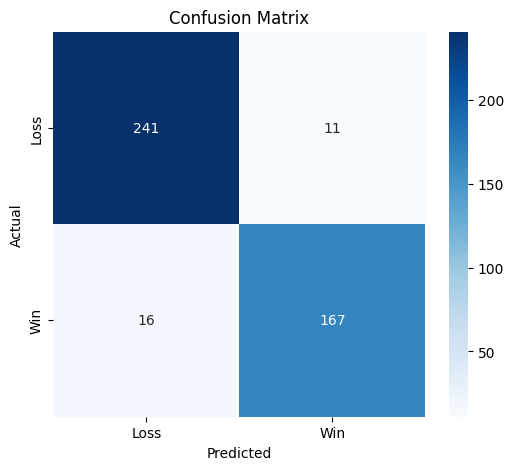

In [126]:
# ===============================
# Accuracy and Confusion Matrix
# ===============================
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Loss", "Win"], yticklabels=["Loss", "Win"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

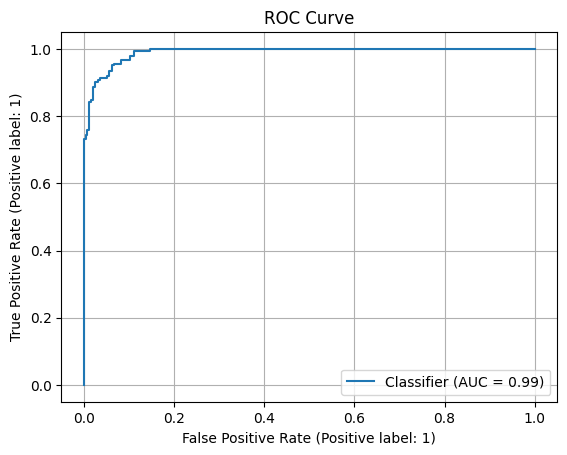

In [129]:
# ===============================
# ROC Curve
# ===============================
RocCurveDisplay.from_predictions(y_true, y_pred_probs)
plt.title("ROC Curve")
plt.grid()
plt.show()

In [128]:
# ===============================
# Classification Report
# ===============================
report = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.loc["accuracy"] = [acc, None, None, None]
report_df.loc["roc_auc"] = [roc_auc_score(y_true, y_pred_probs), None, None, None]
print("📊 Model Evaluation Report")
display(report_df)

📊 Model Evaluation Report


,precision,recall,f1-score,support
0,0.937743,0.956349,0.946955,252.0
1,0.938202,0.912568,0.925208,183.0
accuracy,0.937931,NaN,NaN,NaN
macro avg,0.937973,0.934459,0.936081,435.0
weighted avg,0.937936,0.937931,0.937806,435.0
roc_auc,0.989982,NaN,NaN,NaN


In [ ]:
###############

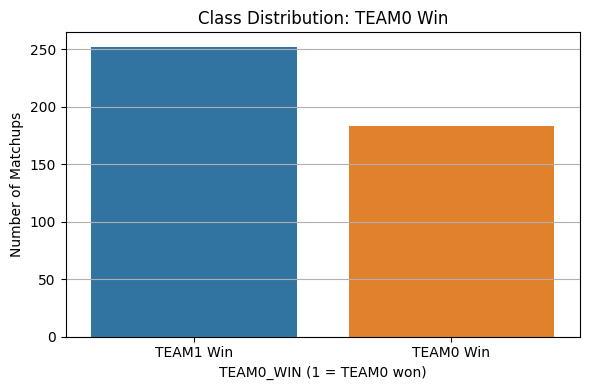

In [115]:
# =========================
# 1. Class Balance
# =========================
plt.figure(figsize=(6, 4))
sns.countplot(x='TEAM0_WIN', data=df)
plt.title("Class Distribution: TEAM0 Win")
plt.xlabel("TEAM0_WIN (1 = TEAM0 won)")
plt.ylabel("Number of Matchups")
plt.xticks([0, 1], ["TEAM1 Win", "TEAM0 Win"])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

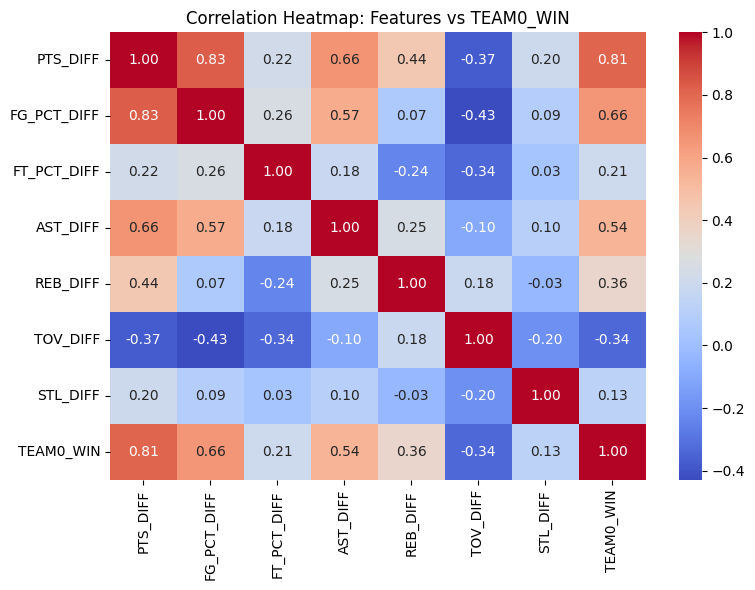

In [116]:
# =========================
# 2. Correlation Heatmap
# =========================
safe_diff_features = [
    'PTS_DIFF', 'FG_PCT_DIFF', 'FT_PCT_DIFF',
    'AST_DIFF', 'REB_DIFF', 'TOV_DIFF', 'STL_DIFF'
]

plt.figure(figsize=(8, 6))
corr_matrix = df[safe_diff_features + ['TEAM0_WIN']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap: Features vs TEAM0_WIN")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like,

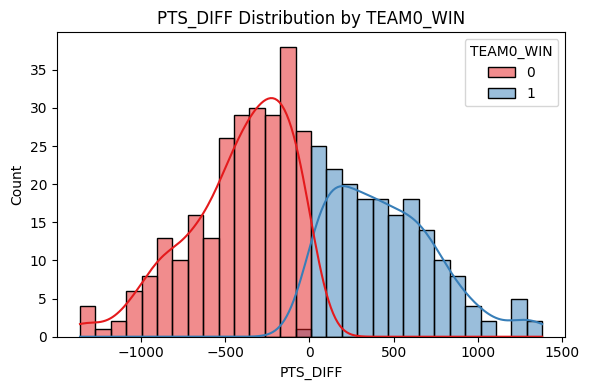

/usr/local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


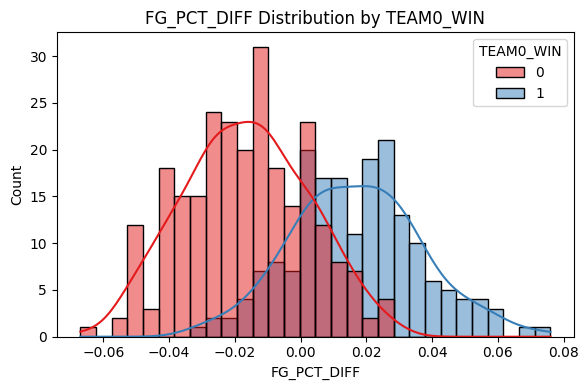

/usr/local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


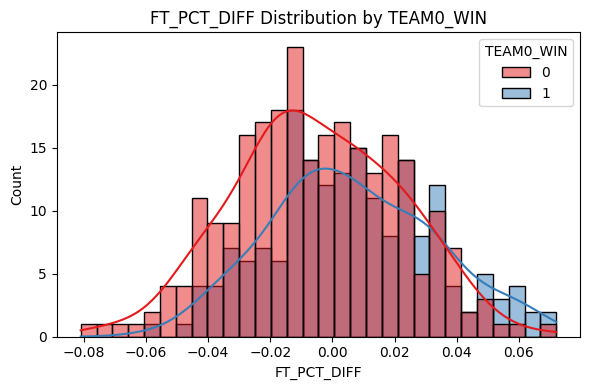

/usr/local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like,

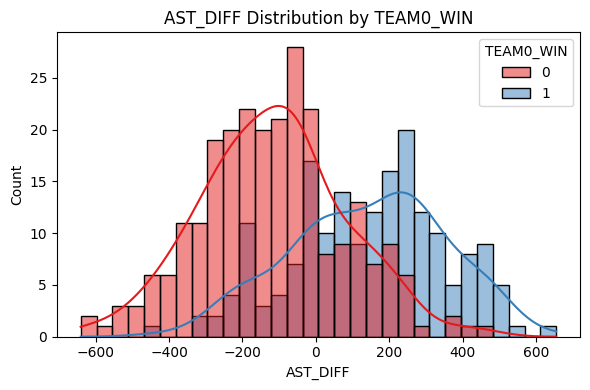

/usr/local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like,

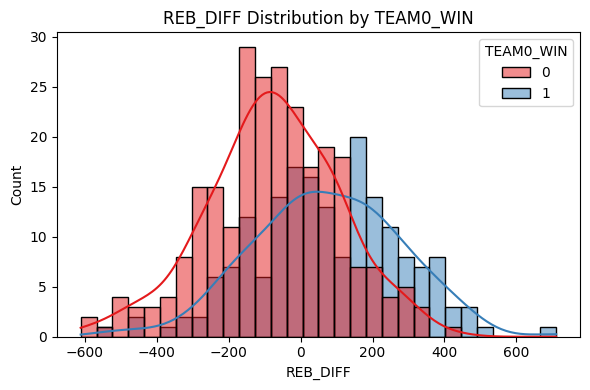

/usr/local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


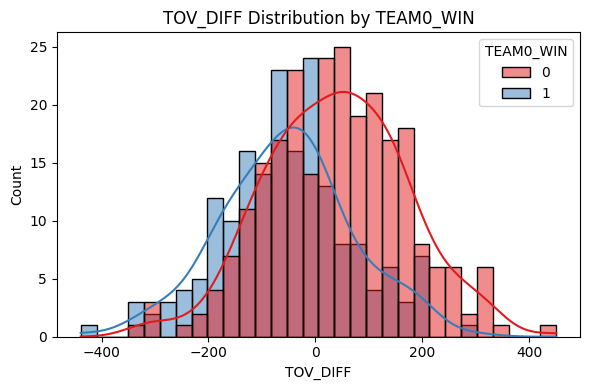

/usr/local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like,

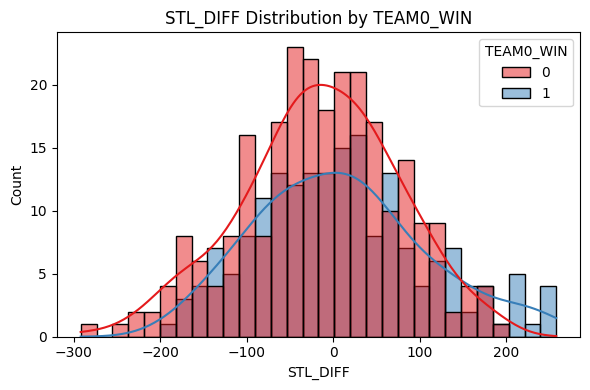

In [117]:
# =========================
# 3. Feature Distributions
# =========================
for feature in safe_diff_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=feature, hue='TEAM0_WIN', kde=True, palette="Set1", bins=30)
    plt.title(f"{feature} Distribution by TEAM0_WIN")
    plt.tight_layout()
    plt.show()

/var/folders/_c/nc23tb4j545_24zwz8plljdm0000gn/T/ipykernel_15543/1492233427.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rates = df.groupby('bin')['TEAM0_WIN'].mean()
/var/folders/_c/nc23tb4j545_24zwz8plljdm0000gn/T/ipykernel_15543/1492233427.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_counts = df.groupby('bin')['TEAM0_WIN'].count()


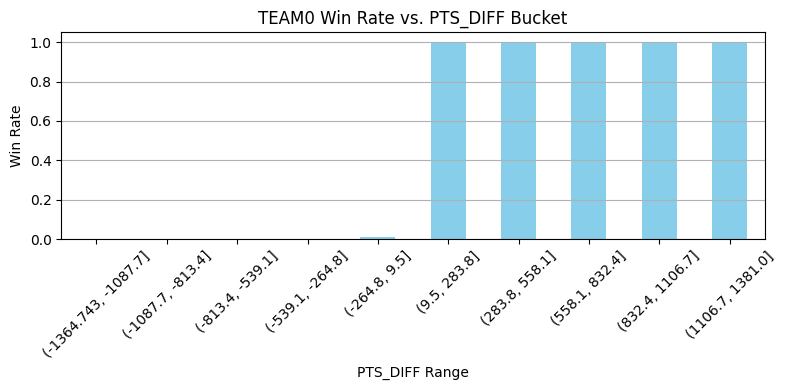

Counts per bin for PTS_DIFF:
 bin
(-1364.743, -1087.7]     7
(-1087.7, -813.4]       27
(-813.4, -539.1]        39
(-539.1, -264.8]        85
(-264.8, 9.5]           95
(9.5, 283.8]            67
(283.8, 558.1]          52
(558.1, 832.4]          42
(832.4, 1106.7]         14
(1106.7, 1381.0]         7
Name: TEAM0_WIN, dtype: int64 



/var/folders/_c/nc23tb4j545_24zwz8plljdm0000gn/T/ipykernel_15543/1492233427.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rates = df.groupby('bin')['TEAM0_WIN'].mean()
/var/folders/_c/nc23tb4j545_24zwz8plljdm0000gn/T/ipykernel_15543/1492233427.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_counts = df.groupby('bin')['TEAM0_WIN'].count()


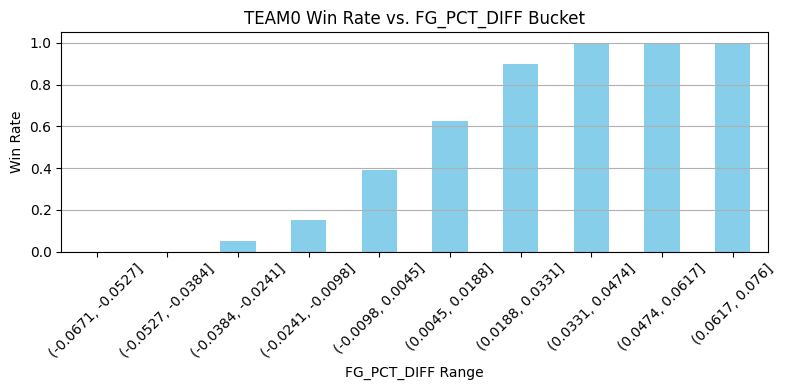

Counts per bin for FG_PCT_DIFF:
 bin
(-0.0671, -0.0527]     3
(-0.0527, -0.0384]    33
(-0.0384, -0.0241]    57
(-0.0241, -0.0098]    87
(-0.0098, 0.0045]     90
(0.0045, 0.0188]      72
(0.0188, 0.0331]      59
(0.0331, 0.0474]      21
(0.0474, 0.0617]      11
(0.0617, 0.076]        2
Name: TEAM0_WIN, dtype: int64 



/var/folders/_c/nc23tb4j545_24zwz8plljdm0000gn/T/ipykernel_15543/1492233427.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rates = df.groupby('bin')['TEAM0_WIN'].mean()
/var/folders/_c/nc23tb4j545_24zwz8plljdm0000gn/T/ipykernel_15543/1492233427.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_counts = df.groupby('bin')['TEAM0_WIN'].count()


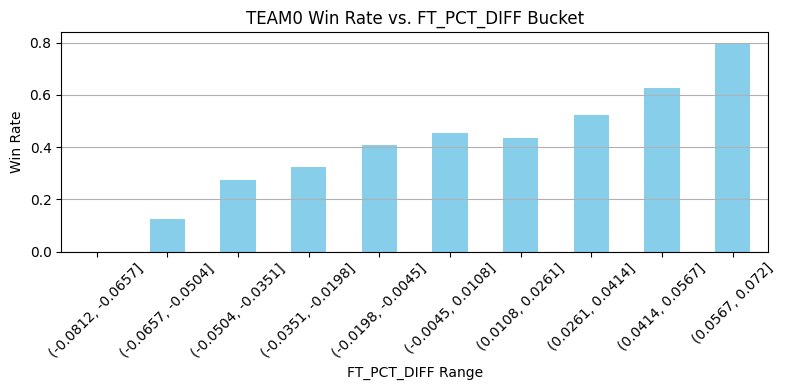

Counts per bin for FT_PCT_DIFF:
 bin
(-0.0812, -0.0657]     3
(-0.0657, -0.0504]     8
(-0.0504, -0.0351]    33
(-0.0351, -0.0198]    62
(-0.0198, -0.0045]    93
(-0.0045, 0.0108]     88
(0.0108, 0.0261]      76
(0.0261, 0.0414]      46
(0.0414, 0.0567]      16
(0.0567, 0.072]       10
Name: TEAM0_WIN, dtype: int64 



/var/folders/_c/nc23tb4j545_24zwz8plljdm0000gn/T/ipykernel_15543/1492233427.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rates = df.groupby('bin')['TEAM0_WIN'].mean()
/var/folders/_c/nc23tb4j545_24zwz8plljdm0000gn/T/ipykernel_15543/1492233427.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_counts = df.groupby('bin')['TEAM0_WIN'].count()


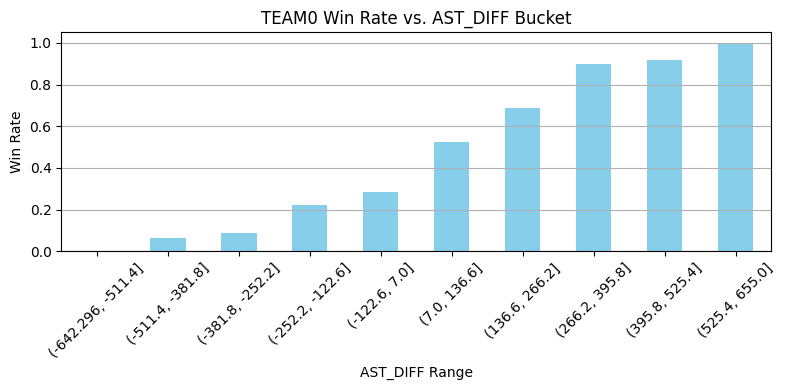

Counts per bin for AST_DIFF:
 bin
(-642.296, -511.4]     6
(-511.4, -381.8]      16
(-381.8, -252.2]      45
(-252.2, -122.6]      80
(-122.6, 7.0]         99
(7.0, 136.6]          63
(136.6, 266.2]        70
(266.2, 395.8]        30
(395.8, 525.4]        24
(525.4, 655.0]         2
Name: TEAM0_WIN, dtype: int64 



/var/folders/_c/nc23tb4j545_24zwz8plljdm0000gn/T/ipykernel_15543/1492233427.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rates = df.groupby('bin')['TEAM0_WIN'].mean()
/var/folders/_c/nc23tb4j545_24zwz8plljdm0000gn/T/ipykernel_15543/1492233427.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_counts = df.groupby('bin')['TEAM0_WIN'].count()


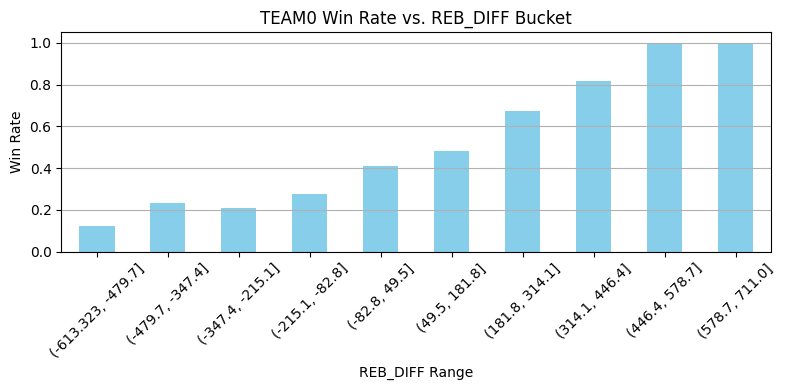

Counts per bin for REB_DIFF:
 bin
(-613.323, -479.7]      8
(-479.7, -347.4]       13
(-347.4, -215.1]       48
(-215.1, -82.8]        91
(-82.8, 49.5]         114
(49.5, 181.8]          85
(181.8, 314.1]         49
(314.1, 446.4]         22
(446.4, 578.7]          4
(578.7, 711.0]          1
Name: TEAM0_WIN, dtype: int64 



/var/folders/_c/nc23tb4j545_24zwz8plljdm0000gn/T/ipykernel_15543/1492233427.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rates = df.groupby('bin')['TEAM0_WIN'].mean()
/var/folders/_c/nc23tb4j545_24zwz8plljdm0000gn/T/ipykernel_15543/1492233427.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_counts = df.groupby('bin')['TEAM0_WIN'].count()


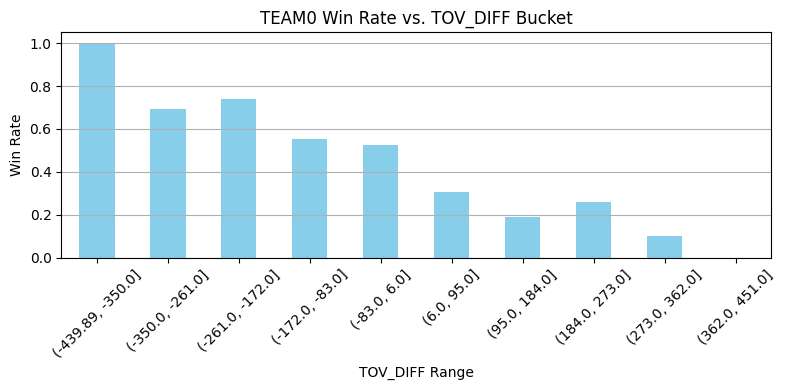

Counts per bin for TOV_DIFF:
 bin
(-439.89, -350.0]      1
(-350.0, -261.0]      13
(-261.0, -172.0]      27
(-172.0, -83.0]       74
(-83.0, 6.0]         118
(6.0, 95.0]           95
(95.0, 184.0]         69
(184.0, 273.0]        27
(273.0, 362.0]        10
(362.0, 451.0]         1
Name: TEAM0_WIN, dtype: int64 



/var/folders/_c/nc23tb4j545_24zwz8plljdm0000gn/T/ipykernel_15543/1492233427.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rates = df.groupby('bin')['TEAM0_WIN'].mean()
/var/folders/_c/nc23tb4j545_24zwz8plljdm0000gn/T/ipykernel_15543/1492233427.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_counts = df.groupby('bin')['TEAM0_WIN'].count()


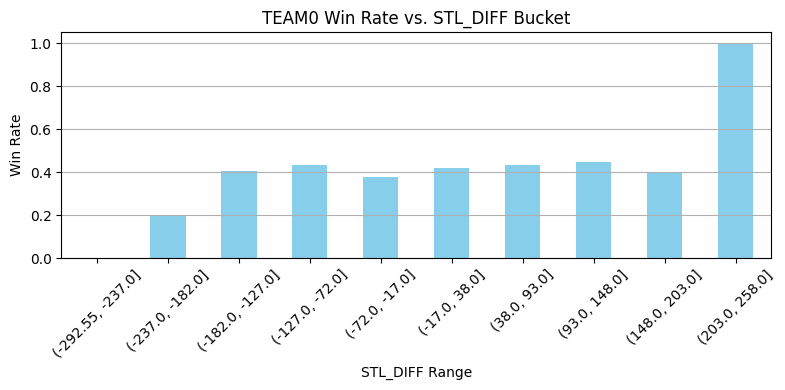

Counts per bin for STL_DIFF:
 bin
(-292.55, -237.0]      2
(-237.0, -182.0]      10
(-182.0, -127.0]      32
(-127.0, -72.0]       58
(-72.0, -17.0]        98
(-17.0, 38.0]        105
(38.0, 93.0]          69
(93.0, 148.0]         36
(148.0, 203.0]        15
(203.0, 258.0]        10
Name: TEAM0_WIN, dtype: int64 



In [118]:
# =========================
# 4. TEAM0 Win Rate by Stat Diff Buckets
# =========================
for feature in safe_diff_features:
    df['bin'] = pd.cut(df[feature], bins=10)
    win_rates = df.groupby('bin')['TEAM0_WIN'].mean()
    win_counts = df.groupby('bin')['TEAM0_WIN'].count()

    plt.figure(figsize=(8, 4))
    win_rates.plot(kind='bar', color='skyblue')
    plt.title(f"TEAM0 Win Rate vs. {feature} Bucket")
    plt.ylabel("Win Rate")
    plt.xlabel(f"{feature} Range")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    print(f"Counts per bin for {feature}:\n", win_counts, "\n")

In [102]:
##############################################

In [81]:
############### PHASE 4: MAKE FINAL PREDICTIONS FOR THE 2025 SEASON ###############

In [93]:
# =========================
# 1. Load Preseason 2025 Data
# =========================
df_stats = pd.read_csv("preseason_2025_full_stats.csv")

nba_teams = [
    "Atlanta Hawks", "Boston Celtics", "Brooklyn Nets", "Charlotte Hornets",
    "Chicago Bulls", "Cleveland Cavaliers", "Dallas Mavericks", "Denver Nuggets",
    "Detroit Pistons", "Golden State Warriors", "Houston Rockets", "Indiana Pacers",
    "LA Clippers", "Los Angeles Lakers", "Memphis Grizzlies", "Miami Heat",
    "Milwaukee Bucks", "Minnesota Timberwolves", "New Orleans Pelicans", "New York Knicks",
    "Oklahoma City Thunder", "Orlando Magic", "Philadelphia 76ers", "Phoenix Suns",
    "Portland Trail Blazers", "Sacramento Kings", "San Antonio Spurs", "Toronto Raptors",
    "Utah Jazz", "Washington Wizards"
]
df_stats = df_stats[df_stats['TEAM_NAME'].isin(nba_teams)].reset_index(drop=True)
df_stats = df_stats.drop(columns=['W_PCT', 'W_PCT_RANK'], errors='ignore')

# =========================
# 2. Generate All Matchups
# =========================
safe_diff_features = ['PTS', 'FG_PCT', 'FT_PCT', 'AST', 'REB', 'TOV', 'STL']
matchups = []
for team0, team1 in permutations(df_stats['TEAM_NAME'], 2):
    row0 = df_stats[df_stats['TEAM_NAME'] == team0].iloc[0]
    row1 = df_stats[df_stats['TEAM_NAME'] == team1].iloc[0]
    
    matchup = {
        'TEAM0': team0,
        'TEAM1': team1
    }
    for col in safe_diff_features:
        matchup[f"{col}_DIFF"] = row0[col] - row1[col]
    
    matchups.append(matchup)

df_future = pd.DataFrame(matchups)

# =========================
# 3. Normalize and Predict
# =========================
X_future = df_future[[f"{col}_DIFF" for col in safe_diff_features]]
scaler = joblib.load("nba_feature_scaler_rnn_v3.pkl")
X_future_scaled = scaler.transform(X_future)
X_future_rnn = X_future_scaled.reshape((X_future_scaled.shape[0], 1, X_future_scaled.shape[1]))

model = load_model("nba_win_predictor_rnn_v3.h5")
preds = model.predict(X_future_rnn)

# =========================
# 4. Format Predictions
# =========================
df_future['TEAM0_WIN_PROB'] = preds.flatten()
df_future['RECOMMENDED_BET'] = np.where(
    df_future['TEAM0_WIN_PROB'] >= 0.5,
    df_future['TEAM0'],
    df_future['TEAM1']
)
df_future['CONFIDENCE'] = np.where(
    df_future['TEAM0_WIN_PROB'] >= 0.5,
    df_future['TEAM0_WIN_PROB'],
    1 - df_future['TEAM0_WIN_PROB']
)

# =========================
# 5. Filter Strong Bets
# =========================
threshold = 0.60
df_bets = df_future[df_future['CONFIDENCE'] >= threshold].copy()
df_bets = df_bets[['TEAM0', 'TEAM1', 'RECOMMENDED_BET', 'CONFIDENCE']]
df_bets = df_bets.sort_values(by='CONFIDENCE', ascending=False).reset_index(drop=True)

# =========================
# 6. Save and Display
# =========================
df_bets.to_csv("2025_moneyline_bet_recommendations.csv", index=False)
print("✅ Saved to 2025_moneyline_bet_recommendations.csv")
display(df_bets.head(-10))

/usr/local/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


 4/28 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
✅ Saved to 2025_moneyline_bet_recommendations.csv


,TEAM0,TEAM1,RECOMMENDED_BET,CONFIDENCE
0,Brooklyn Nets,Oklahoma City Thunder,Oklahoma City Thunder,0.998239
1,Brooklyn Nets,Memphis Grizzlies,Memphis Grizzlies,0.998153
2,Brooklyn Nets,Cleveland Cavaliers,Cleveland Cavaliers,0.998144
3,Orlando Magic,Oklahoma City Thunder,Oklahoma City Thunder,0.998121
4,Brooklyn Nets,Denver Nuggets,Denver Nuggets,0.997808
...,...,...,...,...
805,Milwaukee Bucks,Phoenix Suns,Phoenix Suns,0.627966
806,Dallas Mavericks,LA Clippers,LA Clippers,0.626451
807,Houston Rockets,LA Clippers,Houston Rockets,0.625007
808,San Antonio Spurs,Golden State Warriors,Golden State Warriors,0.624956


In [103]:
################## ANALYSIS ##################

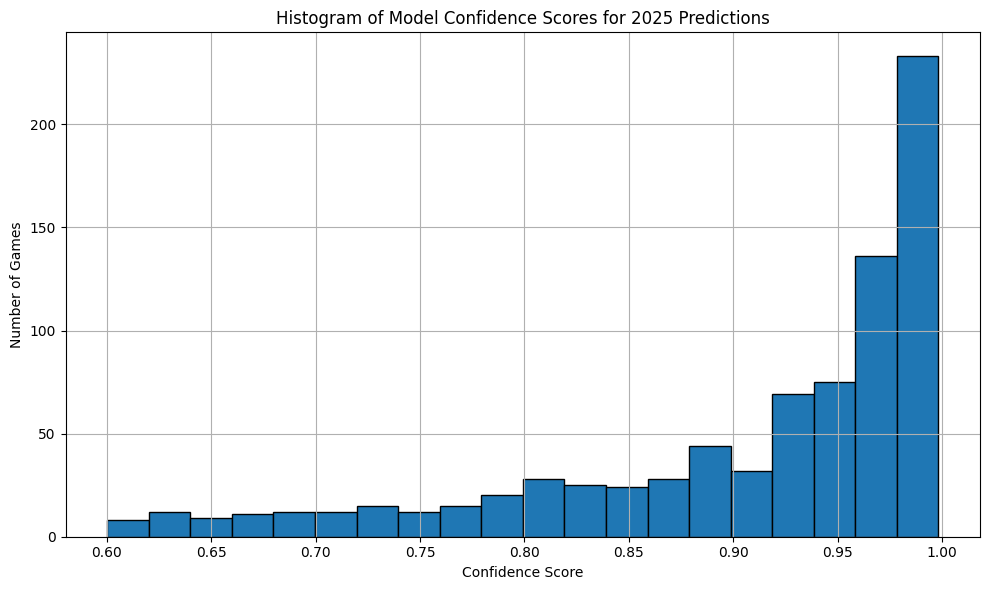

In [130]:
# =========================
# 1. Histogram of Model Confidence Scores
# =========================

# Load prediction results
df_bets = pd.read_csv("2025_moneyline_bet_recommendations.csv")

# Plot histogram of confidence scores
plt.figure(figsize=(10, 6))
plt.hist(df_bets["CONFIDENCE"], bins=20, edgecolor="black")
plt.title("Histogram of Model Confidence Scores for 2025 Predictions")
plt.xlabel("Confidence Score")
plt.ylabel("Number of Games")
plt.grid(True)
plt.tight_layout()
plt.show()

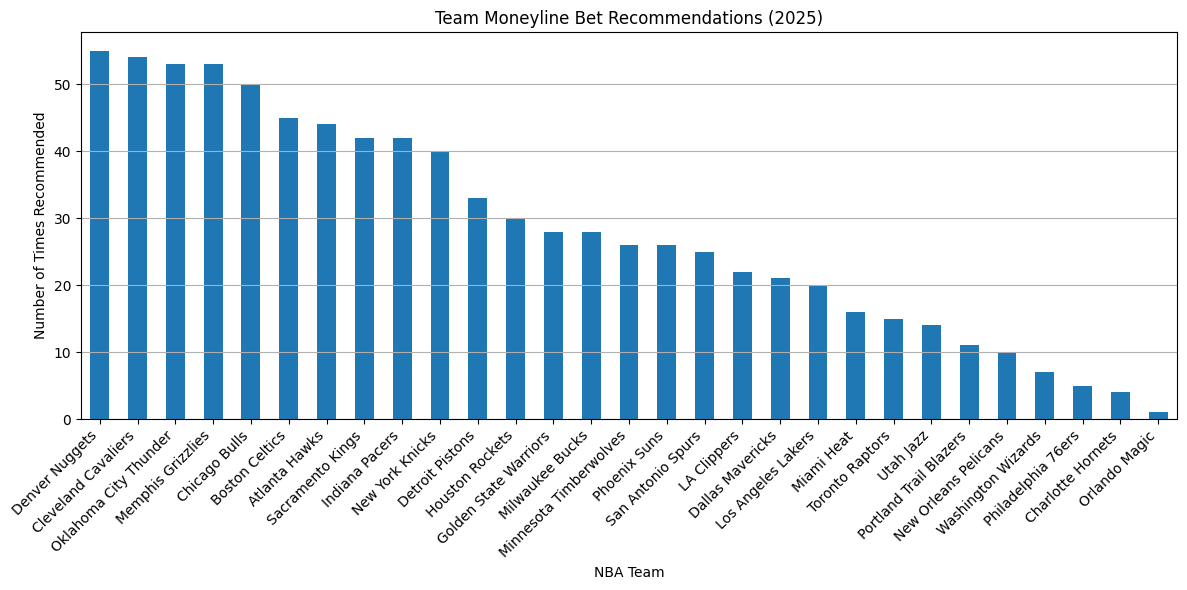

In [131]:
# =========================
# 2. Count of Team Recommendations
# =========================

# Count how many times each team was recommended
team_counts = df_bets["RECOMMENDED_BET"].value_counts().sort_values(ascending=False)

# Plot bar chart of team recommendation counts
plt.figure(figsize=(12, 6))
team_counts.plot(kind="bar")
plt.title("Team Moneyline Bet Recommendations (2025)")
plt.xlabel("NBA Team")
plt.ylabel("Number of Times Recommended")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [104]:
##############################################

In [56]:
################### OLD ~ DISREGARD FOR NOW #####################

In [94]:
# Dataframe 2: Just 2025 ELO Predictions

# STEP 1: Load the full ELO dataset
df_elo = pd.read_csv("nba_elo.csv")
df_elo.columns = df_elo.columns.str.strip()

# STEP 2: Convert date column to datetime
df_elo['GAME_DATE'] = pd.to_datetime(df_elo['date'], errors='coerce')

# STEP 3: Filter to only 2025 games
df_elo_2025 = df_elo[df_elo['GAME_DATE'].dt.year == 2025].copy()

# ✅ STEP 4: Rename relevant columns for TEAM1 and TEAM2 ELOs (only ONCE!)
team1_df = df_elo_2025.rename(columns={
    'team1': 'TEAM_ABBREVIATION',
    'elo1_pre': 'ELO',
    'score1': 'SCORE',
    'is_home': 'IS_HOME'
})[['TEAM_ABBREVIATION', 'GAME_DATE', 'ELO', 'SCORE', 'IS_HOME']]
team1_df['TEAM_ORDER'] = 0  # team1 is usually home

team2_df = df_elo_2025.rename(columns={
    'team2': 'TEAM_ABBREVIATION',
    'elo2_pre': 'ELO',
    'score2': 'SCORE',
    'is_home': 'IS_HOME'
})[['TEAM_ABBREVIATION', 'GAME_DATE', 'ELO', 'SCORE', 'IS_HOME']]
team2_df['TEAM_ORDER'] = 1  # team2 is usually away

# STEP 5: Combine both teams
elo_2025_combined = pd.concat([team1_df, team2_df], ignore_index=True)

# Optional: sort and reset index
elo_2025_combined = elo_2025_combined.sort_values(['GAME_DATE', 'TEAM_ORDER']).reset_index(drop=True)

# STEP 6: Pivot 2025 ELOs into TEAM0 and TEAM1 pairings
team0_2025 = elo_2025_combined[elo_2025_combined['TEAM_ORDER'] == 0].copy()
team1_2025 = elo_2025_combined[elo_2025_combined['TEAM_ORDER'] == 1].copy()

# Merge by GAME_DATE to get matchup
elo_2025_paired = pd.merge(
    team0_2025, team1_2025,
    on='GAME_DATE',
    suffixes=('_TEAM0', '_TEAM1')
)

elo_2025_paired.to_csv("nba_elo_2025_pairwise.csv", index=False)
display(elo_2025_paired.head(50))

,TEAM_ABBREVIATION_TEAM0,GAME_DATE,ELO_TEAM0,SCORE_TEAM0,IS_HOME_TEAM0,TEAM_ORDER_TEAM0,TEAM_ABBREVIATION_TEAM1,ELO_TEAM1,SCORE_TEAM1,IS_HOME_TEAM1,TEAM_ORDER_TEAM1
0,DEN,2025-01-01,1592.839072,139,1,0,ATL,1512.982916,120,1,1
1,DEN,2025-01-01,1592.839072,139,1,0,DEN,1592.839072,139,0,1
2,DEN,2025-01-01,1592.839072,139,1,0,ORL,1549.455058,96,1,1
3,DEN,2025-01-01,1592.839072,139,1,0,DET,1427.194001,105,0,1
4,DEN,2025-01-01,1592.839072,139,1,0,DAL,1613.209591,99,1,1
5,DEN,2025-01-01,1592.839072,139,1,0,HOU,1591.609467,110,0,1
6,DEN,2025-01-01,1592.839072,139,1,0,NOP,1335.557593,108,1,1
7,DEN,2025-01-01,1592.839072,139,1,0,MIA,1556.549834,119,0,1
8,DEN,2025-01-01,1592.839072,139,1,0,UTA,1372.436361,103,1,1
9,DEN,2025-01-01,1592.839072,139,1,0,NYK,1661.170215,119,0,1


In [48]:
# Regenerate Synthetic Data With All Needed Columns

# Load preseason stats
df_stats = pd.read_csv("preseason_2025_full_stats.csv").copy()
df_stats = df_stats.rename(columns={'TEAM_NAME': 'Team'})

# Drop leaky columns
leaky_cols = ['W', 'L', 'W_PCT'] + [col for col in df_stats.columns if 'RANK' in col]
df_stats = df_stats.drop(columns=leaky_cols)

# Get list of team names
teams = df_stats['Team'].tolist()

# Generate synthetic matchups
matchups = []
for team0 in teams:
    for team1 in teams:
        if team0 != team1:
            matchups.append((team0, team1))

np.random.seed(42)
synthetic_rows = []
for team0, team1 in matchups:
    row = {}

    # Select a random home team
    team0_is_home = np.random.choice([0, 1])
    team1_is_home = 1 - team0_is_home
    row['TEAM_ORDER_TEAM0'] = 0 if team0_is_home else 1
    row['TEAM_ORDER_TEAM1'] = 1 if team0_is_home else 0

    row['TEAM_ABBREVIATION_TEAM0'] = team0
    row['TEAM_ABBREVIATION_TEAM1'] = team1

    stats0 = df_stats[df_stats['Team'] == team0].drop(columns='Team').squeeze()
    stats1 = df_stats[df_stats['Team'] == team1].drop(columns='Team').squeeze()

    for col in stats0.index:
        row[f"{col}_DIFF"] = stats0[col] - stats1[col]

    # Add fake ELOs
    team0_elo = np.random.normal(loc=1500, scale=100)
    team1_elo = np.random.normal(loc=1500, scale=100)
    row['TEAM0_ELO'] = team0_elo
    row['TEAM1_ELO'] = team1_elo
    row['ELO_DIFF'] = team0_elo - team1_elo
    row['ELO_SUM'] = team0_elo + team1_elo
    row['TEAM0_IS_HOME'] = team0_is_home
    row['TEAM1_IS_HOME'] = team1_is_home

    synthetic_rows.append(row)

# Save dataset
df_synth = pd.DataFrame(synthetic_rows)
df_synth.to_csv("synthetic_matchups_2025.csv", index=False)
print("✅ Regenerated synthetic_matchups_2025.csv with ELO and home/away columns")




✅ Regenerated synthetic_matchups_2025.csv with ELO and home/away columns


In [55]:
# =============================================================================
# 6. Enhanced 2025 Prediction Using Stat Differences & 2025 ELO Dataset
# =============================================================================

# Load synthetic matchups for training/prediction
df_train = pd.read_csv("synthetic_matchups_2025.csv")

# Add derived features (if not already added)
df_train['ELO_DIFF'] = df_train['TEAM0_ELO'] - df_train['TEAM1_ELO']
df_train['ELO_SUM'] = df_train['TEAM0_ELO'] + df_train['TEAM1_ELO']
df_train['TEAM0_IS_HOME'] = (df_train['TEAM_ORDER_TEAM0'] == 0).astype(int)
df_train['TEAM1_IS_HOME'] = (df_train['TEAM_ORDER_TEAM1'] == 0).astype(int)

# Define input features (MUST match model)
numeric_features = [
    'FG_PCT_DIFF',       # Field goal percentage diff
    'FG3_PCT_DIFF',      # 3-point percentage diff
    'FT_PCT_DIFF',       # Free throw percentage diff
    'OREB_DIFF',         # Offensive rebound diff
    'TOV_DIFF',          # Turnover diff
    'ELO_DIFF',          # ELO difference
    'TEAM0_IS_HOME'      # Home advantage
]

# Fit the scaler on these features
X_train_for_scaler = df_train[numeric_features].fillna(0)
scaler = StandardScaler()
scaler.fit(X_train_for_scaler)

# Save the scaler
joblib.dump(scaler, "nba_feature_scaler_rnn_v3.pkl")
print("✅ Refit scaler on enhanced feature set and saved as nba_feature_scaler_rnn_v3.pkl")

# Prepare input for RNN
X_2025 = df_train[numeric_features].fillna(0)
scaler = joblib.load("nba_feature_scaler_rnn_v3.pkl")
X_2025_scaled = scaler.transform(X_2025)
X_2025_rnn = X_2025_scaled.reshape((X_2025_scaled.shape[0], 1, X_2025_scaled.shape[1]))
print("✅ Final shape for prediction:", X_2025_rnn.shape)

# Predict with RNN model
preds = model_rnn.predict(X_2025_rnn)
df_train['TEAM0_WIN_PROB'] = preds
df_train['PREDICTED_WINNER'] = np.where(
    df_train['TEAM0_WIN_PROB'] >= 0.5,
    df_train['TEAM_ABBREVIATION_TEAM0'],
    df_train['TEAM_ABBREVIATION_TEAM1']
)

print("✅ Finished generating enhanced predictions")

# =============================================================================
# 7. Evaluate Enhanced 2025 Predictions (Real Outcomes)
# =============================================================================

# Load true 2025 outcomes
df_actual = pd.read_csv("nba_elo_2025_pairwise.csv").copy()

# Create matchup ID for merging
df_actual['MATCHUP_ID'] = (
    df_actual['GAME_DATE'] + "_" +
    df_actual['TEAM_ABBREVIATION_TEAM0'] + "_" +
    df_actual['TEAM_ABBREVIATION_TEAM1']
)

df_train['MATCHUP_ID'] = (
    df_train['GAME_DATE'] + "_" +
    df_train['TEAM_ABBREVIATION_TEAM0'] + "_" +
    df_train['TEAM_ABBREVIATION_TEAM1']
)

# Determine actual winner
df_actual['ACTUAL_WINNER'] = np.where(
    df_actual['SCORE_TEAM0'] > df_actual['SCORE_TEAM1'],
    df_actual['TEAM_ABBREVIATION_TEAM0'],
    df_actual['TEAM_ABBREVIATION_TEAM1']
)

# Merge predictions with actual outcomes
df_merged = df_actual.merge(
    df_train[['MATCHUP_ID', 'TEAM0_WIN_PROB', 'PREDICTED_WINNER']],
    on='MATCHUP_ID',
    how='inner'
)

# Accuracy
accuracy = np.mean(df_merged['PREDICTED_WINNER'] == df_merged['ACTUAL_WINNER'])
print(f"✅ 2025 Enhanced Prediction Accuracy: {accuracy:.2%}")

# Class distribution
print("🏀 PREDICTED WINNERS (Top 10):")
print(df_merged['PREDICTED_WINNER'].value_counts(normalize=True).head(10))

print("🏀 ACTUAL WINNERS (Top 10):")
print(df_merged['ACTUAL_WINNER'].value_counts(normalize=True).head(10))

# Confusion matrix
df_merged['TEAM0_WIN'] = (df_actual['SCORE_TEAM0'] > df_actual['SCORE_TEAM1']).astype(int)
df_merged['PRED_TEAM0_WIN'] = (df_merged['TEAM0_WIN_PROB'] >= 0.5).astype(int)

print("🧾 Confusion Matrix (TEAM0 win binary):")
print(pd.crosstab(df_merged['TEAM0_WIN'], df_merged['PRED_TEAM0_WIN'],
                  rownames=['Actual TEAM0_WIN'], colnames=['Predicted TEAM0_WIN'], margins=True))

# Save predictions
df_merged[['GAME_DATE', 'TEAM_ABBREVIATION_TEAM0', 'TEAM_ABBREVIATION_TEAM1',
           'TEAM0_WIN_PROB', 'PREDICTED_WINNER', 'ACTUAL_WINNER']].to_csv(
    "2025_enhanced_predictions.csv", index=False
)

print("📁 Saved enhanced predictions to 2025_enhanced_predictions.csv")

✅ Refit scaler on enhanced feature set and saved as nba_feature_scaler_rnn_v3.pkl
✅ Final shape for prediction: (870, 1, 7)


/usr/local/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
✅ Finished generating enhanced predictions


KeyError: 'GAME_DATE'